In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import sklearn.cross_validation

from collections import Counter
import math
import time
from scipy import stats

import sys
%matplotlib inline
pd.set_option('display.max_columns', None)

In [8]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [16]:
leads = pd.read_csv('leads.csv')

In [39]:
leads.corr()

,Unnamed: 0,user_id,First_Lead_Price,Avg_Lead_Price,Max_Lead_Price,Min_Lead_Price,Leads_Submitted,Talk_Count,Met,Saved_Searches,Activated,Registered,Spanish,bedrooms,bathrooms,square_feet
Unnamed: 0,1.000000,-0.056447,0.081190,0.086771,0.071875,0.089559,-0.028602,0.011894,0.006966,0.011062,-0.016047,-0.018024,-0.022618,0.044007,0.030449,-0.008787
user_id,-0.056447,1.000000,0.005053,0.005293,0.007389,0.002552,0.029316,-0.026007,-0.020085,-0.129041,-0.027801,-0.055656,0.137794,-0.010292,-0.025625,-0.020202
First_Lead_Price,0.081190,0.005053,1.000000,0.938609,0.896830,0.913072,-0.019901,-0.006869,-0.006863,-0.015997,0.008810,-0.007402,-0.023586,0.218219,0.460600,0.545144
Avg_Lead_Price,0.086771,0.005293,0.938609,1.000000,0.910878,0.972381,-0.026223,-0.011712,-0.006039,-0.016227,0.002795,-0.007788,-0.026210,0.218225,0.446455,0.523609
Max_Lead_Price,0.071875,0.007389,0.896830,0.910878,1.000000,0.827718,0.017087,0.005401,-0.004218,-0.000323,0.014182,0.007586,-0.002111,0.194387,0.412492,0.481053
Min_Lead_Price,0.089559,0.002552,0.913072,0.972381,0.827718,1.000000,-0.050657,-0.021467,-0.008190,-0.026275,-0.005494,-0.019861,-0.036085,0.217433,0.438052,0.512483
Leads_Submitted,-0.028602,0.029316,-0.019901,-0.026223,0.017087,-0.050657,1.000000,0.419824,0.096061,0.185079,0.108108,0.145225,0.169945,-0.007178,-0.033566,-0.041275
Talk_Count,0.011894,-0.026007,-0.006869,-0.011712,0.005401,-0.021467,0.419824,1.000000,0.378801,0.131297,0.049767,0.071019,0.071292,0.004011,0.004273,-0.009394
Met,0.006966,-0.020085,-0.006863,-0.006039,-0.004218,-0.008190,0.096061,0.378801,1.000000,0.032425,0.017062,0.002878,-0.006879,-0.001875,0.007200,-0.001886
Saved_Searches,0.011062,-0.129041,-0.015997,-0.016227,-0.000323,-0.026275,0.185079,0.131297,0.032425,1.000000,0.311001,0.455970,0.148412,0.015482,-0.002243,-0.015323


In [44]:
leads.describe()

,Unnamed: 0,user_id,First_Lead_Price,Avg_Lead_Price,Max_Lead_Price,Min_Lead_Price,Leads_Submitted,Talk_Count,Met,Saved_Searches,Activated,Registered,Spanish,bedrooms,bathrooms,square_feet
count,30648.000000,3.064800e+04,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000,30648.000000
mean,564749.829190,3.224196e+08,239478.713750,239190.167613,261239.077623,223374.129568,2.437223,1.205429,0.136877,0.636159,0.085291,0.163241,0.046300,3.163469,2.190766,1864.747063
std,286077.746651,2.009181e+08,698590.162563,677094.833645,838495.179822,632710.375357,4.067372,1.948271,0.343723,1.300808,0.279319,0.369591,0.210137,1.151735,0.922730,1136.326692
min,12.000000,3.286200e+04,5000.000000,5000.000000,5000.000000,3500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,50.000000
25%,329452.000000,1.531580e+08,80000.000000,84900.000000,90000.000000,74900.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1210.000000
50%,570180.000000,3.016576e+08,149900.000000,149993.500000,159900.000000,139900.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1601.000000
75%,824662.500000,4.543018e+08,259500.000000,259900.000000,274999.250000,249500.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,2.500000,2206.000000
max,1025529.000000,7.341008e+08,55000000.000000,55000000.000000,55000000.000000,55000000.000000,165.000000,69.000000,1.000000,63.000000,1.000000,1.000000,1.000000,106.000000,21.500000,33000.000000


Unnamed: 0


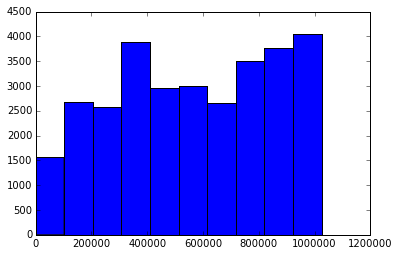

user_id


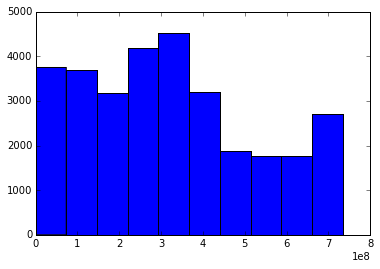

First_Lead_Price


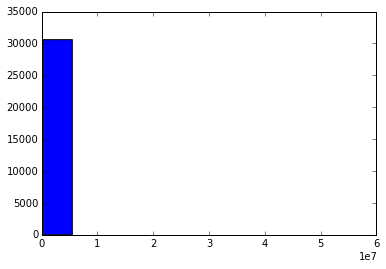

Avg_Lead_Price


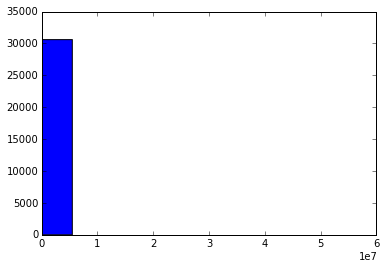

Max_Lead_Price


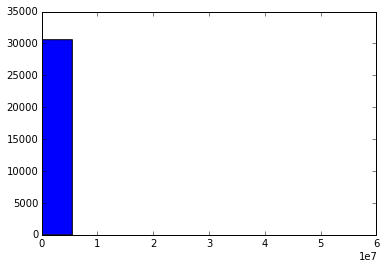

Min_Lead_Price


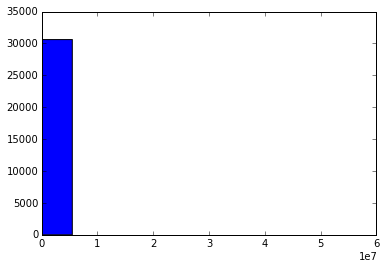

Leads_Submitted


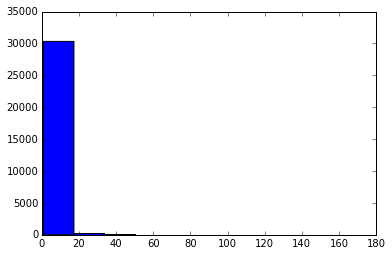

Talk_Count


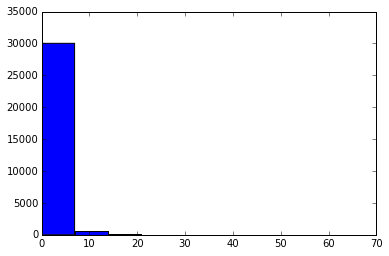

Met


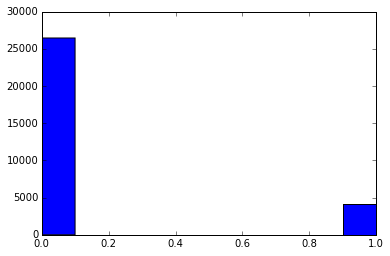

Saved_Searches


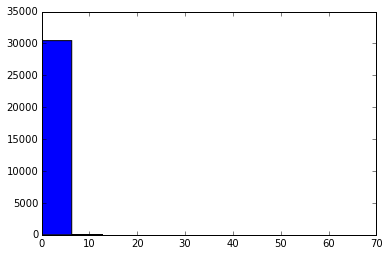

Activated


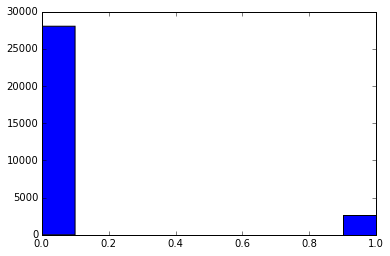

Registered


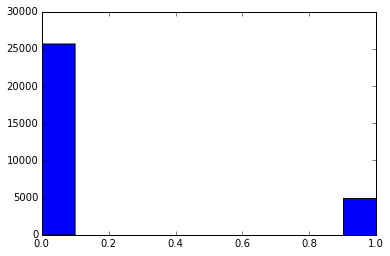

Spanish


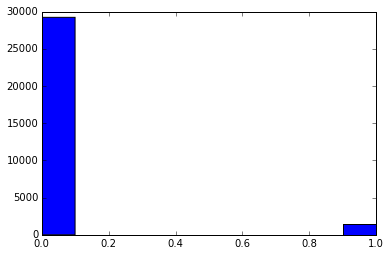

bedrooms


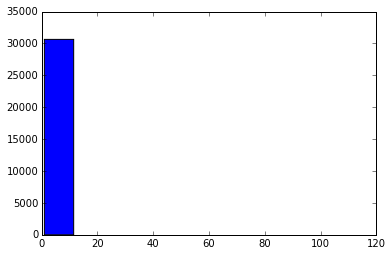

bathrooms


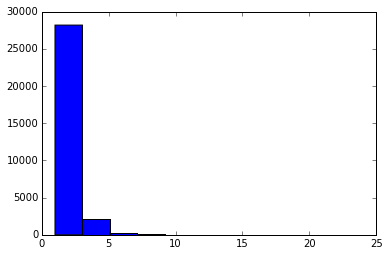

square_feet


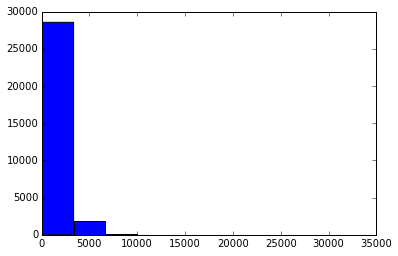

In [48]:
excepted = ['First_Lead_Platform', 'State']
for i in leads:
    if i not in excepted:
        print i
        plt.hist(leads[i])
        plt.show()

In [41]:
count = 0
for i in leads['Met']:
    if i == 1:
        count += 1
print count
print count/float(len(leads['Met']))
print len(leads['Met'])

4195
0.136876794571
30648


In [38]:
columns = ['Leads_Submitted','Talk_Count','Saved_Searches', 'Met']
new = pd.DataFrame(leads, columns = columns)
new.corr()

,Leads_Submitted,Talk_Count,Saved_Searches,Met
Leads_Submitted,1.000000,0.419824,0.185079,0.096061
Talk_Count,0.419824,1.000000,0.131297,0.378801
Saved_Searches,0.185079,0.131297,1.000000,0.032425
Met,0.096061,0.378801,0.032425,1.000000


<function matplotlib.pyplot.show>

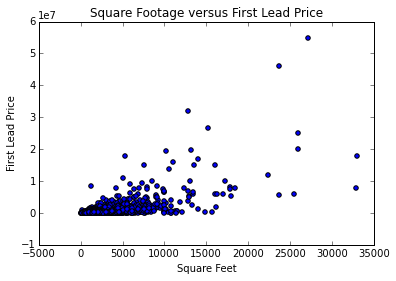

In [34]:
plt.scatter(leads['square_feet'], leads['First_Lead_Price'])
plt.title('Square Footage versus First Lead Price')
plt.xlabel('Square Feet')
plt.ylabel('First Lead Price')
plt.show

In [5]:
one_hot_columns = ['First_Lead_Platform', 'State']
for i in one_hot_columns:
    dummies = pd.get_dummies(leads[i])
    for j in dummies:
        leads[j] = dummies[j]

In [ ]:
# numvars, numdata = 4, 10
# data = 10 * np.random.random((numvars, numdata))
# fig = scatterplot_matrix(data, ['mpg', 'disp', 'drat', 'wt'],
#         linestyle='none', marker='o', color='black', mfc='none')
# fig.suptitle('Simple Scatterplot Matrix')
# plt.show()

# def scatterplot_matrix(data, names, **kwargs):
#     """Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
#     against other rows, resulting in a nrows by nrows grid of subplots with the
#     diagonal subplots labeled with "names".  Additional keyword arguments are
#     passed on to matplotlib's "plot" command. Returns the matplotlib figure
#     object containg the subplot grid."""
#     numvars, numdata = data.shape
#     fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8,8))
#     fig.subplots_adjust(hspace=0.05, wspace=0.05)

Unnamed: 0


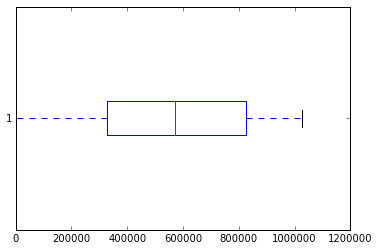

user_id


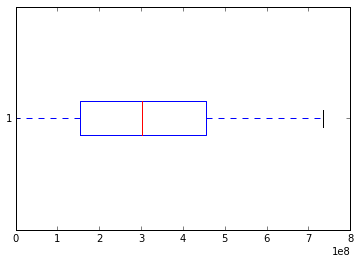

First_Lead_Price


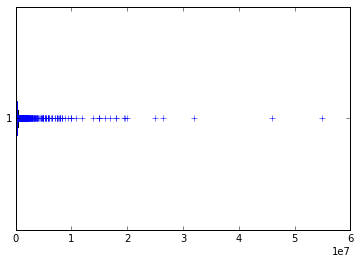

Avg_Lead_Price


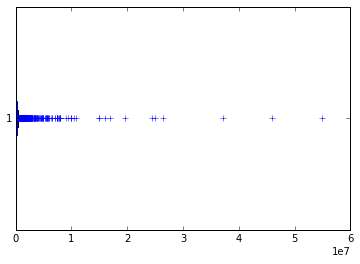

Max_Lead_Price


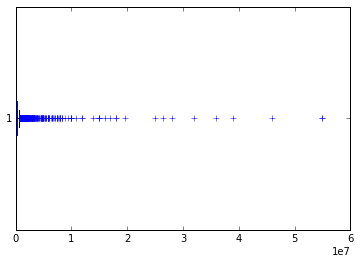

Min_Lead_Price


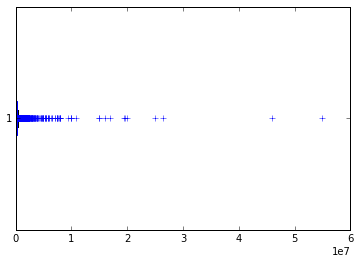

Leads_Submitted


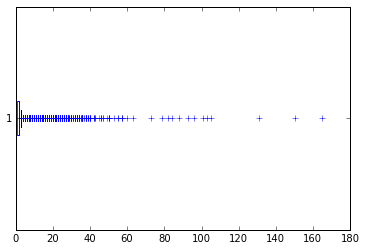

Talk_Count


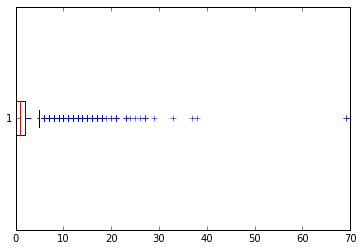

Met


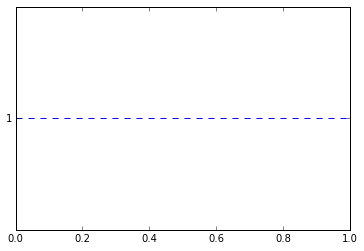

Saved_Searches


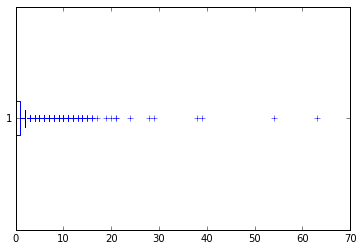

Activated


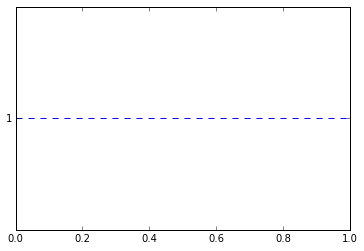

Registered


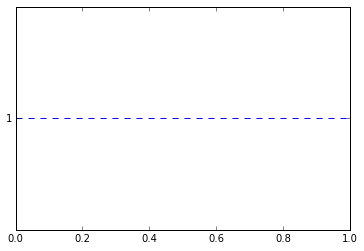

Spanish


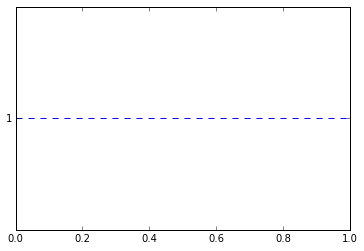

bedrooms


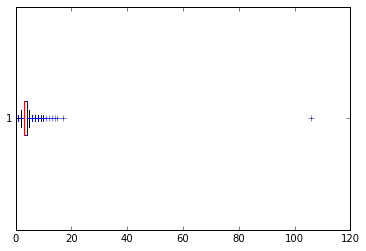

bathrooms


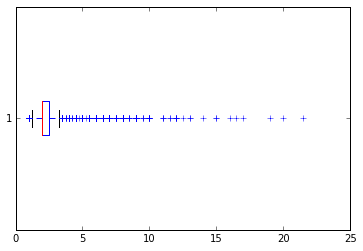

square_feet


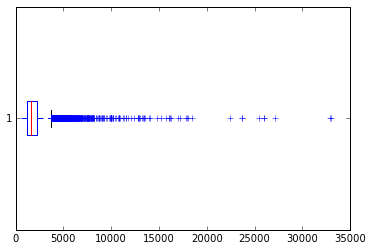

In [4]:
out = ['First_Lead_Platform', 'State']
for i in leads:
    if i not in out:
        print i
        plt.boxplot(leads[i], vert = False)
        plt.show()

('Unnamed: 0', 'Unnamed: 0')


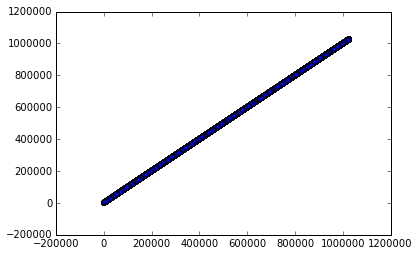

('Unnamed: 0', 'user_id')


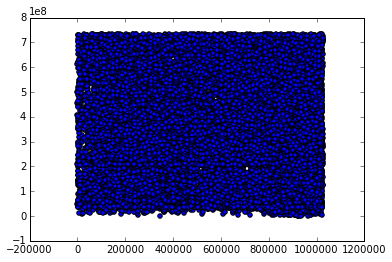

('Unnamed: 0', 'First_Lead_Price')


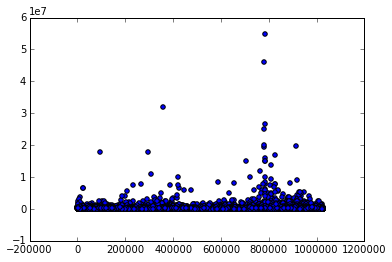

('Unnamed: 0', 'Avg_Lead_Price')


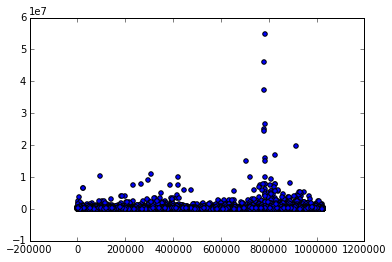

('Unnamed: 0', 'Max_Lead_Price')


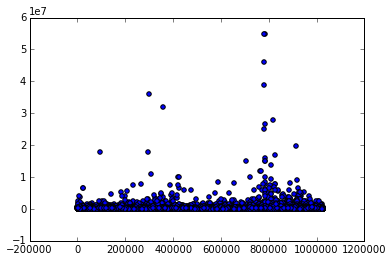

('Unnamed: 0', 'Min_Lead_Price')


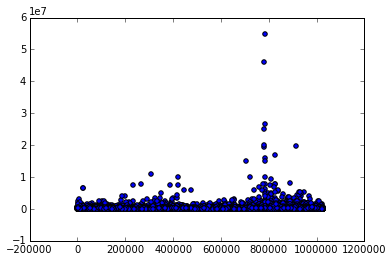

('Unnamed: 0', 'Leads_Submitted')


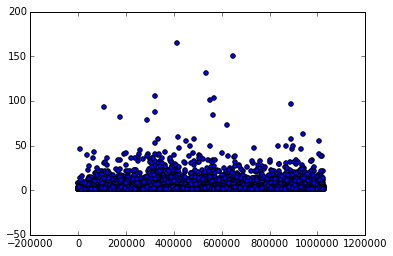

('Unnamed: 0', 'Talk_Count')


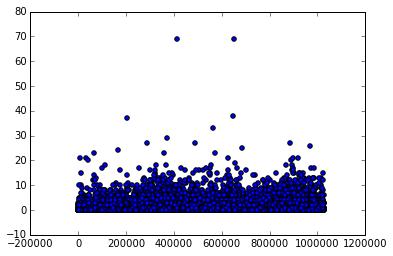

('Unnamed: 0', 'Met')


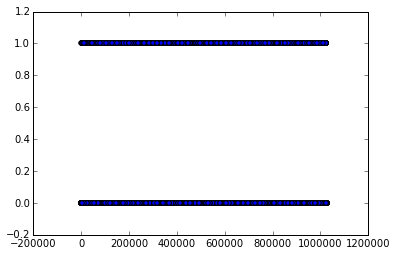

('Unnamed: 0', 'Saved_Searches')


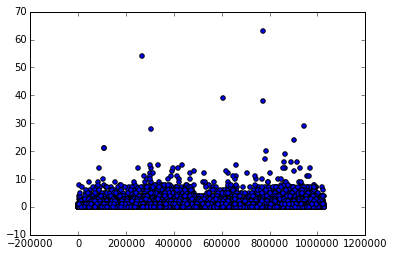

('Unnamed: 0', 'Activated')


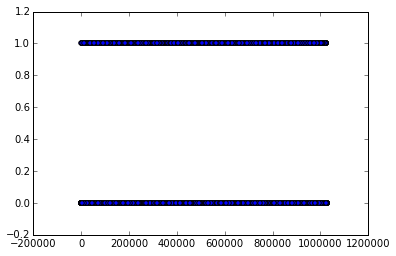

('Unnamed: 0', 'Registered')


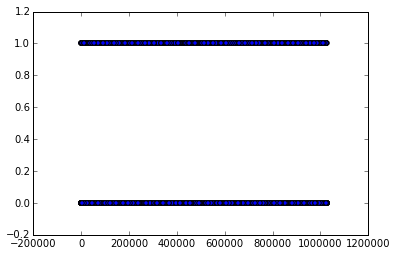

('Unnamed: 0', 'Spanish')


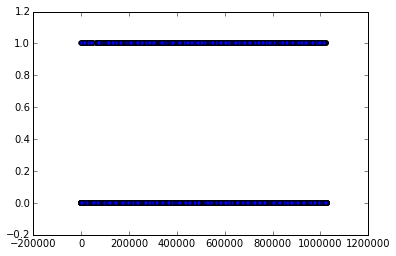

('Unnamed: 0', 'bedrooms')


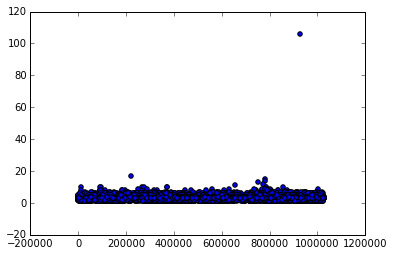

('Unnamed: 0', 'bathrooms')


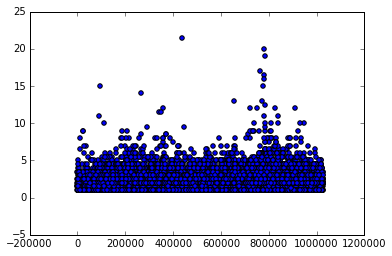

('Unnamed: 0', 'square_feet')


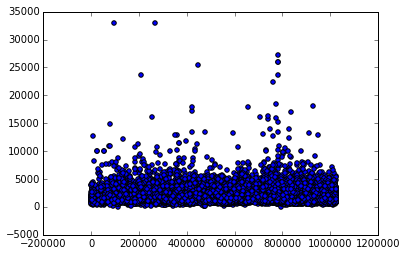

('user_id', 'Unnamed: 0')


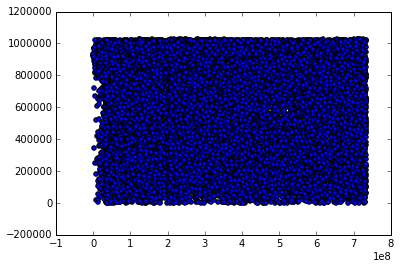

('user_id', 'user_id')


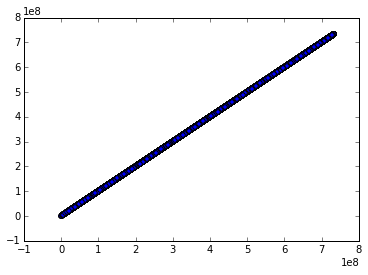

('user_id', 'First_Lead_Price')


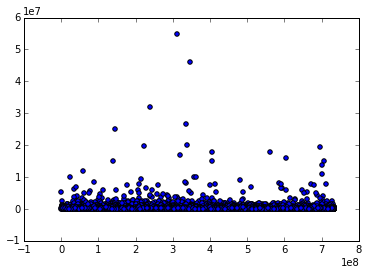

('user_id', 'Avg_Lead_Price')


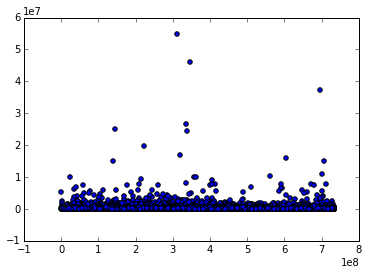

('user_id', 'Max_Lead_Price')


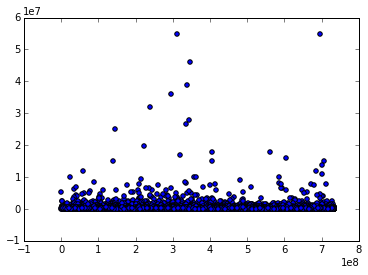

('user_id', 'Min_Lead_Price')


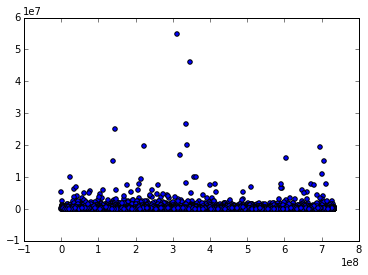

('user_id', 'Leads_Submitted')


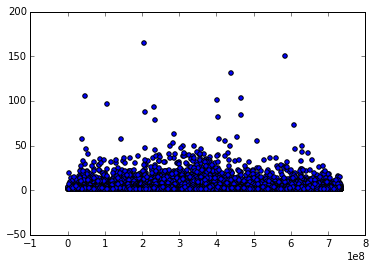

('user_id', 'Talk_Count')


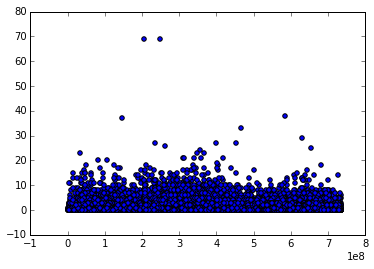

('user_id', 'Met')


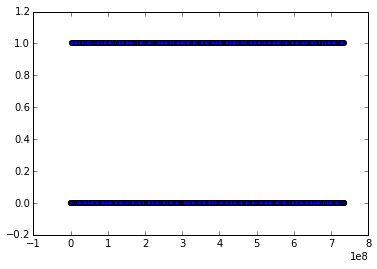

('user_id', 'Saved_Searches')


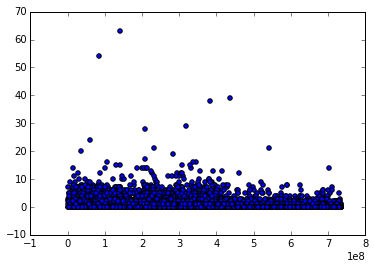

('user_id', 'Activated')


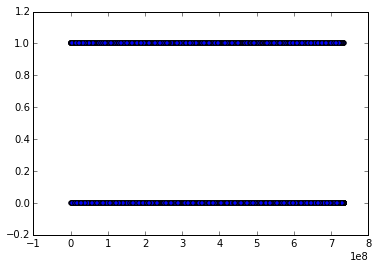

('user_id', 'Registered')


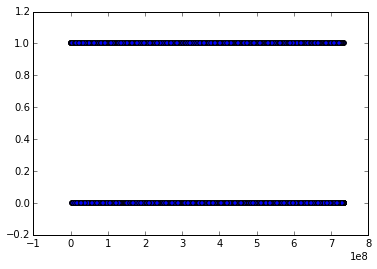

('user_id', 'Spanish')


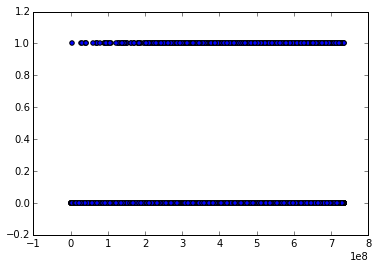

('user_id', 'bedrooms')


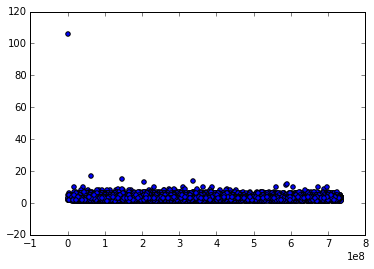

('user_id', 'bathrooms')


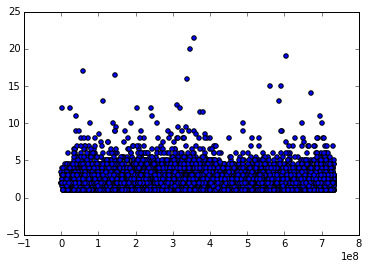

('user_id', 'square_feet')


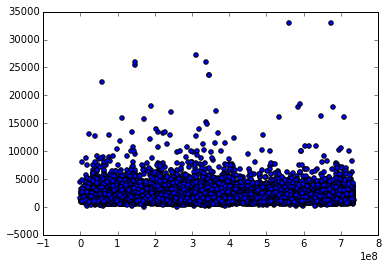

('First_Lead_Price', 'Unnamed: 0')


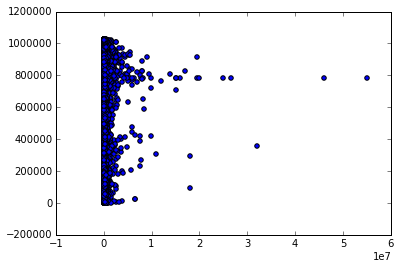

('First_Lead_Price', 'user_id')


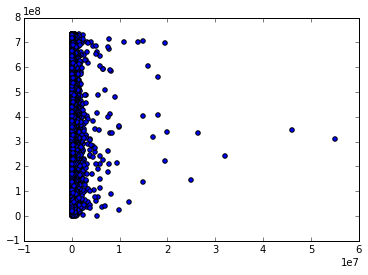

('First_Lead_Price', 'First_Lead_Price')


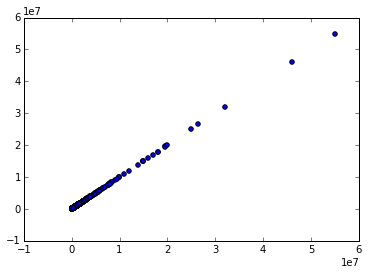

('First_Lead_Price', 'Avg_Lead_Price')


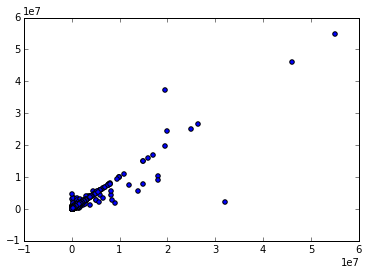

('First_Lead_Price', 'Max_Lead_Price')


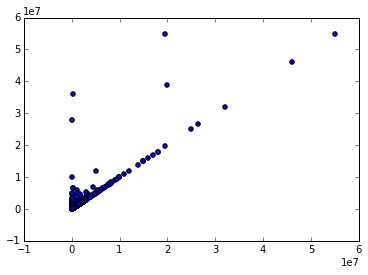

('First_Lead_Price', 'Min_Lead_Price')


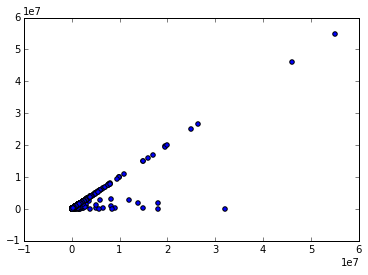

('First_Lead_Price', 'Leads_Submitted')


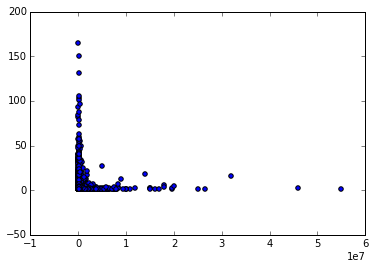

('First_Lead_Price', 'Talk_Count')


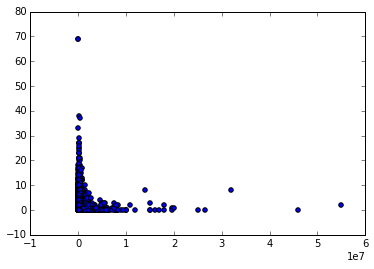

('First_Lead_Price', 'Met')


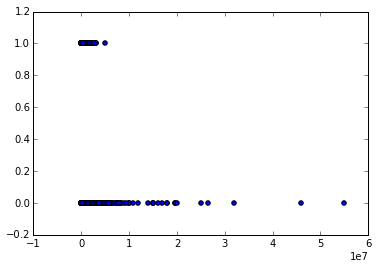

('First_Lead_Price', 'Saved_Searches')


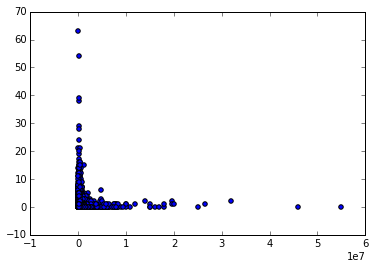

('First_Lead_Price', 'Activated')


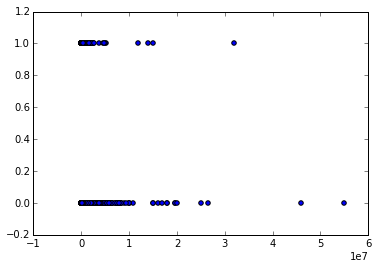

('First_Lead_Price', 'Registered')


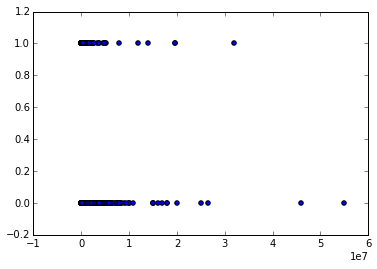

('First_Lead_Price', 'Spanish')


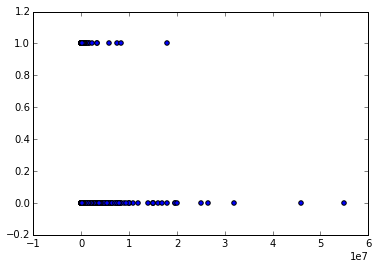

('First_Lead_Price', 'bedrooms')


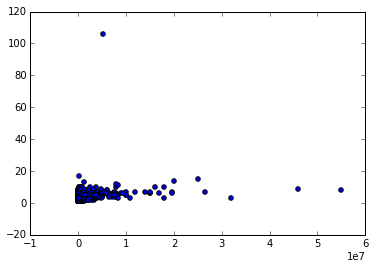

('First_Lead_Price', 'bathrooms')


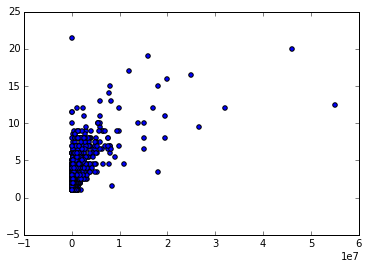

('First_Lead_Price', 'square_feet')


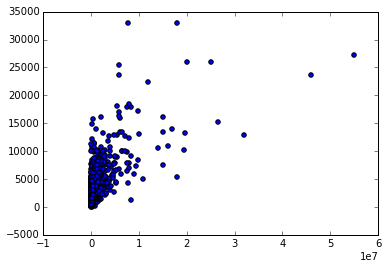

('Avg_Lead_Price', 'Unnamed: 0')


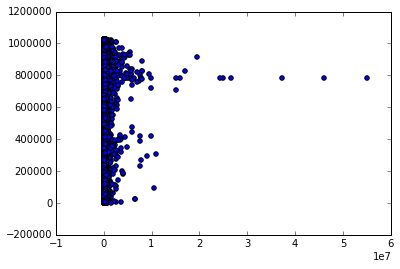

('Avg_Lead_Price', 'user_id')


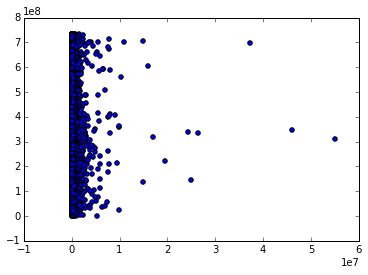

('Avg_Lead_Price', 'First_Lead_Price')


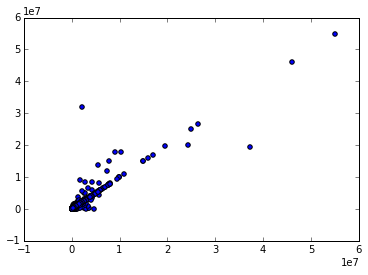

('Avg_Lead_Price', 'Avg_Lead_Price')


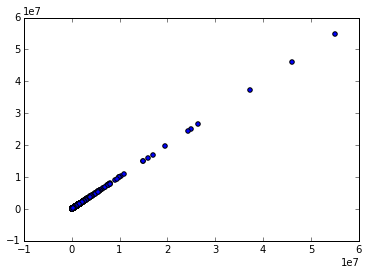

('Avg_Lead_Price', 'Max_Lead_Price')


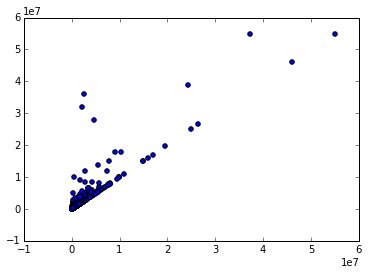

('Avg_Lead_Price', 'Min_Lead_Price')


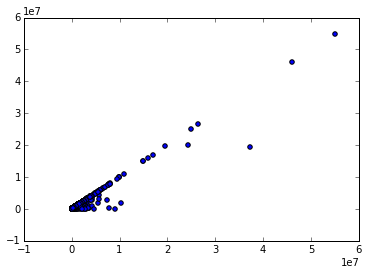

('Avg_Lead_Price', 'Leads_Submitted')


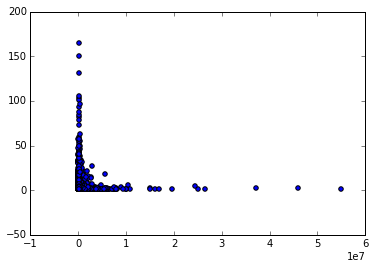

('Avg_Lead_Price', 'Talk_Count')


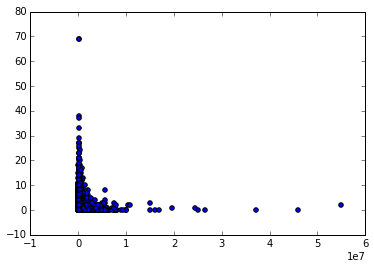

('Avg_Lead_Price', 'Met')


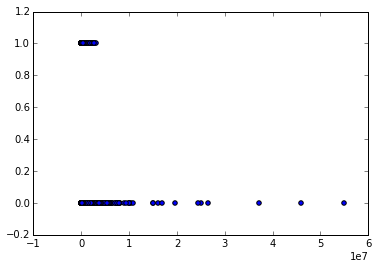

('Avg_Lead_Price', 'Saved_Searches')


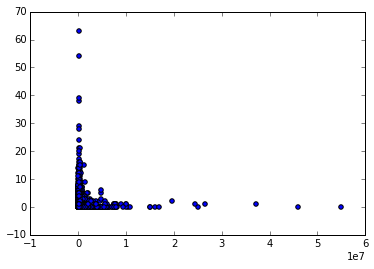

('Avg_Lead_Price', 'Activated')


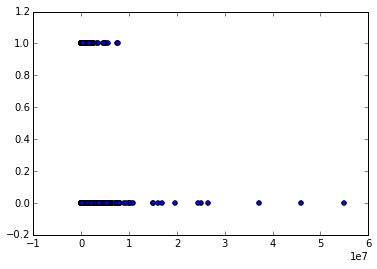

('Avg_Lead_Price', 'Registered')


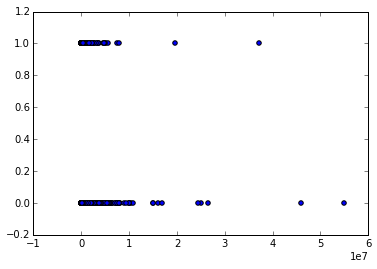

('Avg_Lead_Price', 'Spanish')


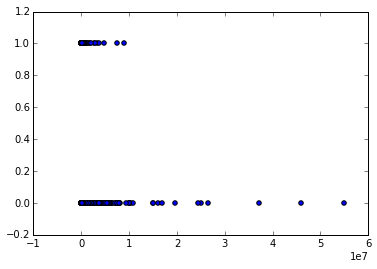

('Avg_Lead_Price', 'bedrooms')


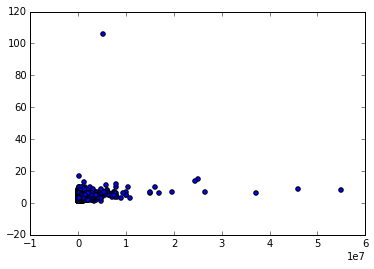

('Avg_Lead_Price', 'bathrooms')


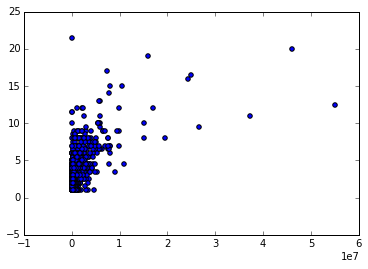

('Avg_Lead_Price', 'square_feet')


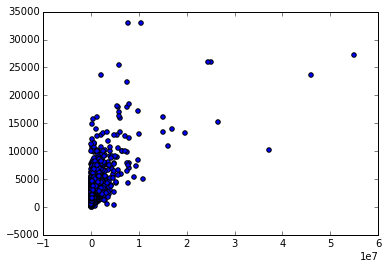

('Max_Lead_Price', 'Unnamed: 0')


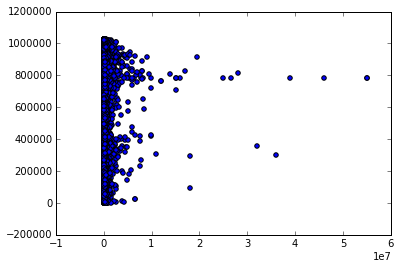

('Max_Lead_Price', 'user_id')


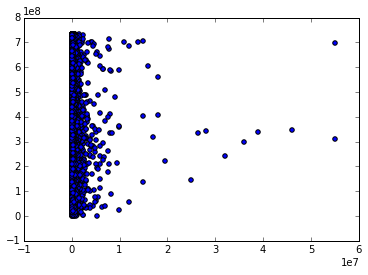

('Max_Lead_Price', 'First_Lead_Price')


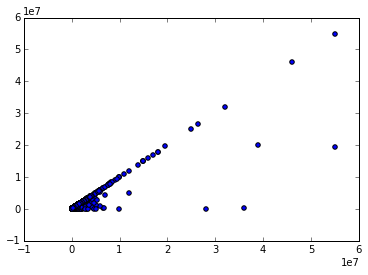

('Max_Lead_Price', 'Avg_Lead_Price')


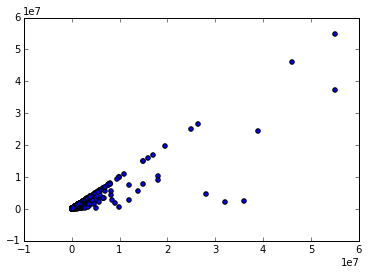

('Max_Lead_Price', 'Max_Lead_Price')


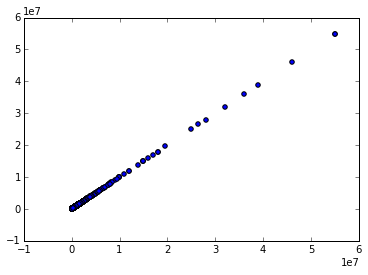

('Max_Lead_Price', 'Min_Lead_Price')


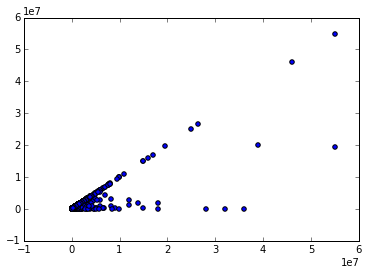

('Max_Lead_Price', 'Leads_Submitted')


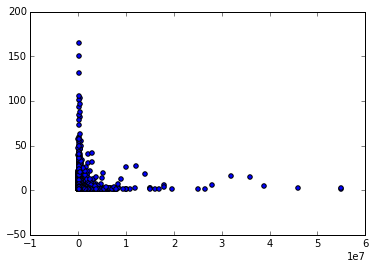

('Max_Lead_Price', 'Talk_Count')


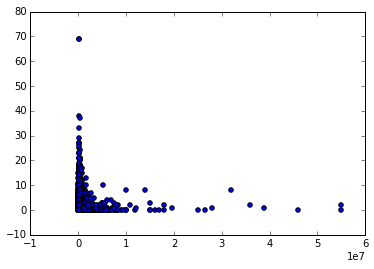

('Max_Lead_Price', 'Met')


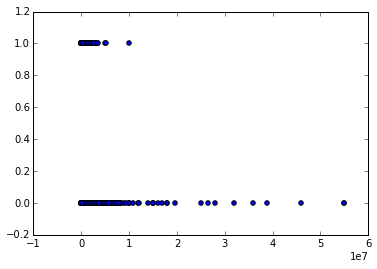

('Max_Lead_Price', 'Saved_Searches')


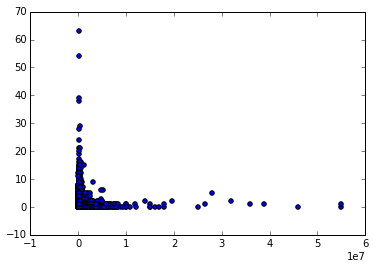

('Max_Lead_Price', 'Activated')


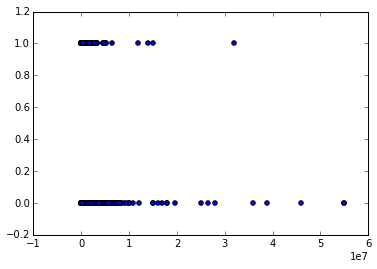

('Max_Lead_Price', 'Registered')


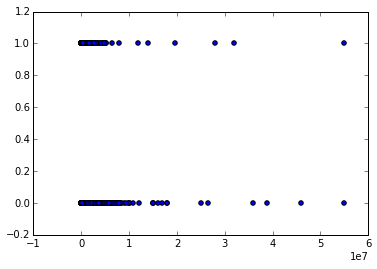

('Max_Lead_Price', 'Spanish')


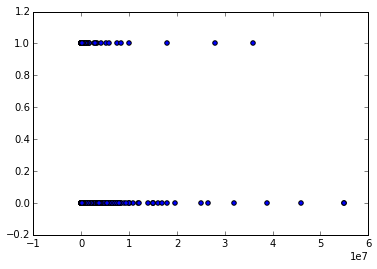

('Max_Lead_Price', 'bedrooms')


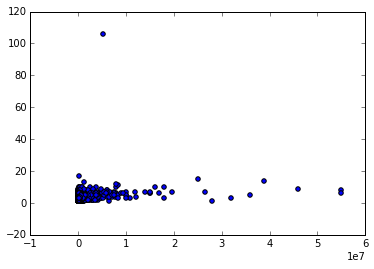

('Max_Lead_Price', 'bathrooms')


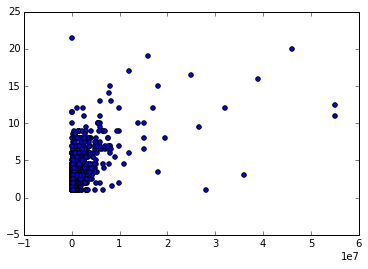

('Max_Lead_Price', 'square_feet')


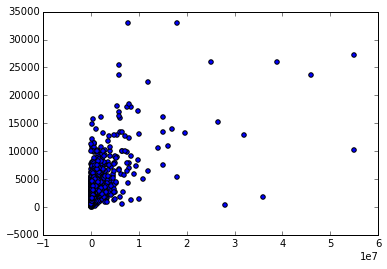

('Min_Lead_Price', 'Unnamed: 0')


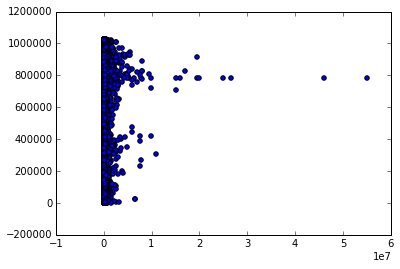

('Min_Lead_Price', 'user_id')


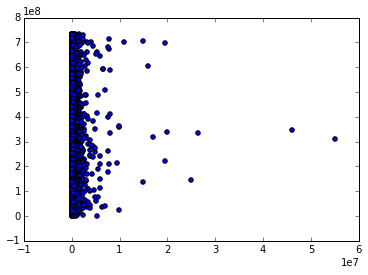

('Min_Lead_Price', 'First_Lead_Price')


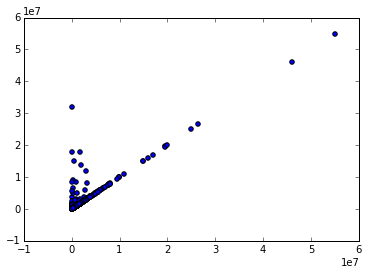

('Min_Lead_Price', 'Avg_Lead_Price')


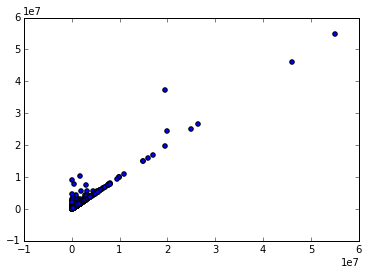

('Min_Lead_Price', 'Max_Lead_Price')


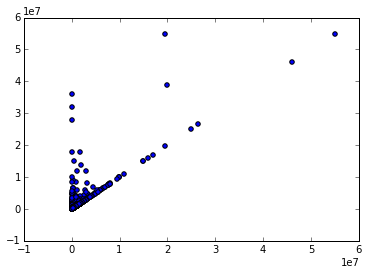

('Min_Lead_Price', 'Min_Lead_Price')


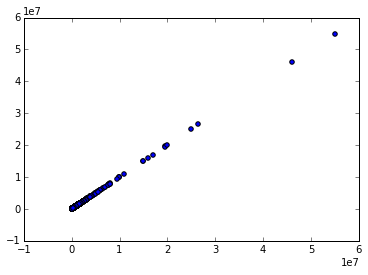

('Min_Lead_Price', 'Leads_Submitted')


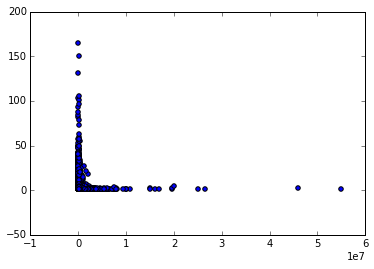

('Min_Lead_Price', 'Talk_Count')


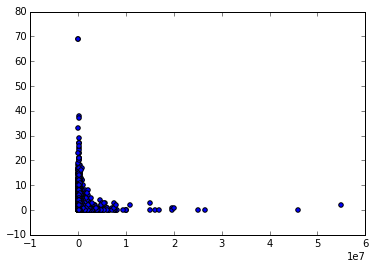

('Min_Lead_Price', 'Met')


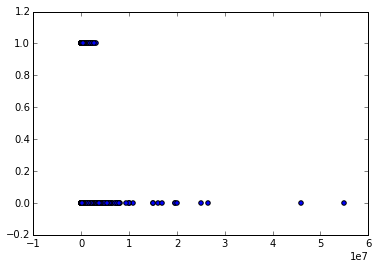

('Min_Lead_Price', 'Saved_Searches')


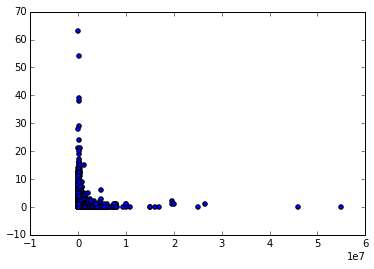

('Min_Lead_Price', 'Activated')


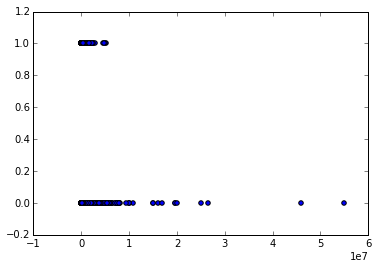

('Min_Lead_Price', 'Registered')


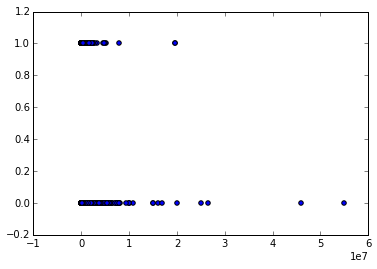

('Min_Lead_Price', 'Spanish')


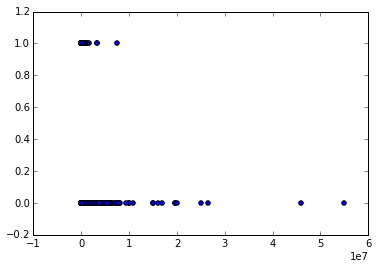

('Min_Lead_Price', 'bedrooms')


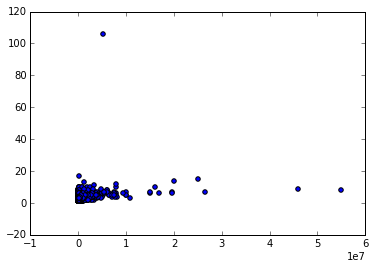

('Min_Lead_Price', 'bathrooms')


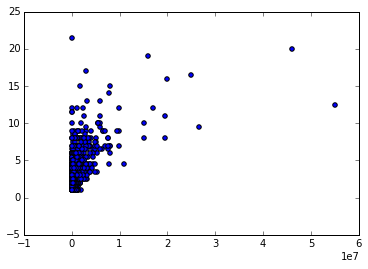

('Min_Lead_Price', 'square_feet')


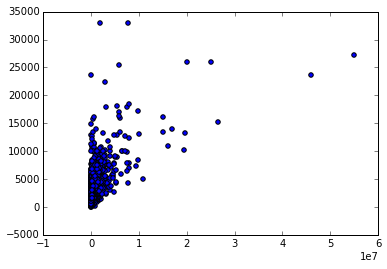

('Leads_Submitted', 'Unnamed: 0')


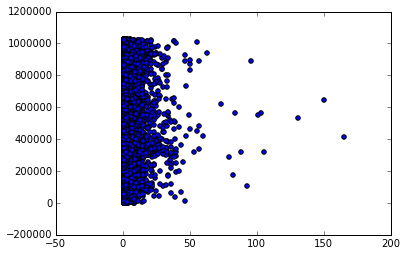

('Leads_Submitted', 'user_id')


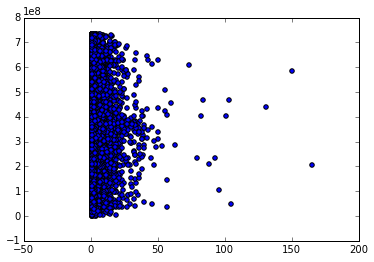

('Leads_Submitted', 'First_Lead_Price')


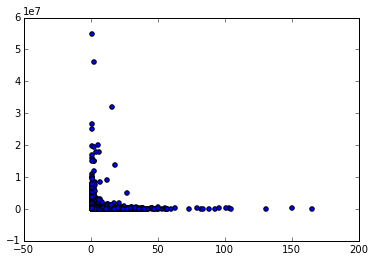

('Leads_Submitted', 'Avg_Lead_Price')


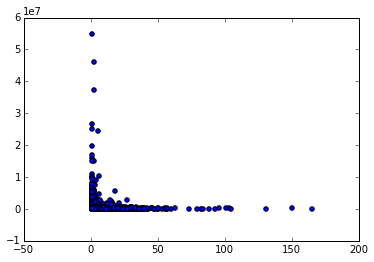

('Leads_Submitted', 'Max_Lead_Price')


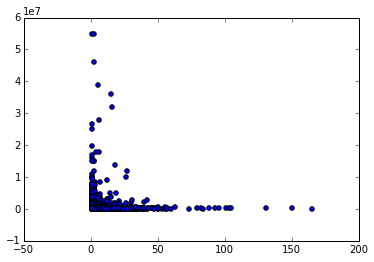

('Leads_Submitted', 'Min_Lead_Price')


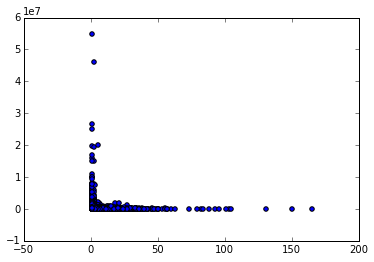

('Leads_Submitted', 'Leads_Submitted')


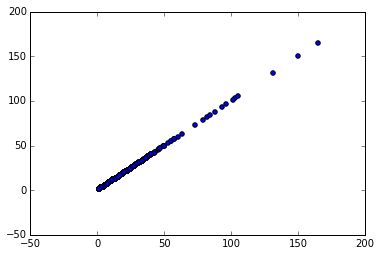

('Leads_Submitted', 'Talk_Count')


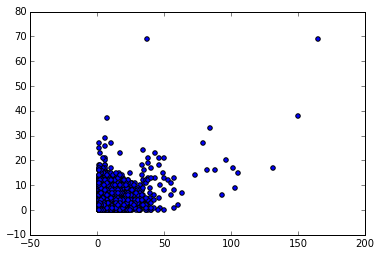

('Leads_Submitted', 'Met')


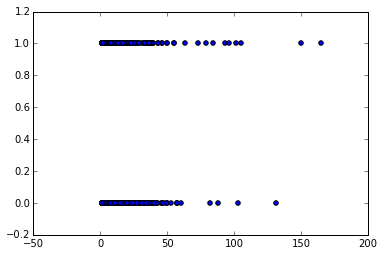

('Leads_Submitted', 'Saved_Searches')


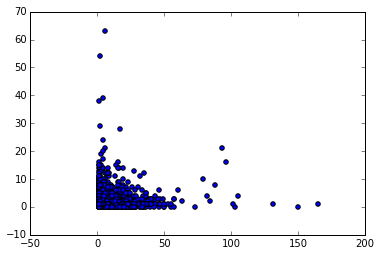

('Leads_Submitted', 'Activated')


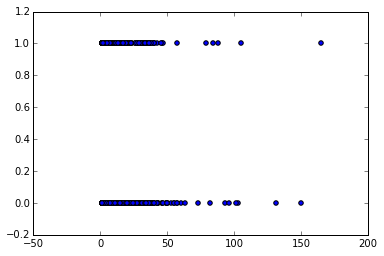

('Leads_Submitted', 'Registered')


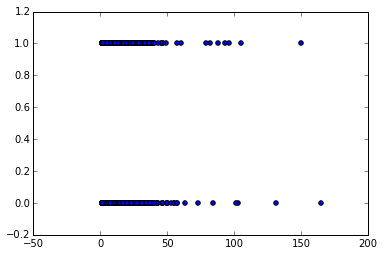

('Leads_Submitted', 'Spanish')


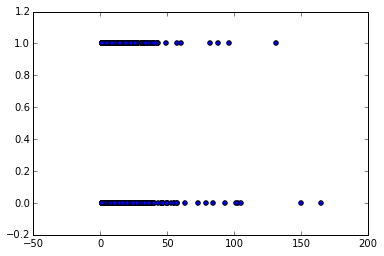

('Leads_Submitted', 'bedrooms')


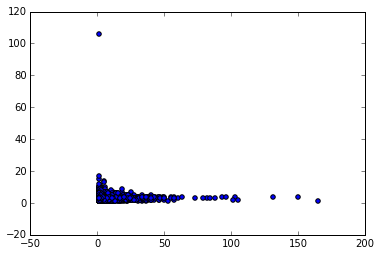

('Leads_Submitted', 'bathrooms')


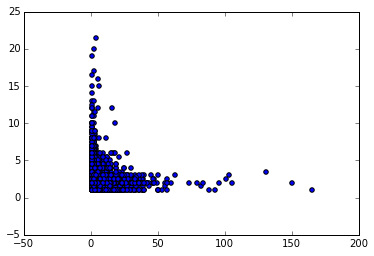

('Leads_Submitted', 'square_feet')


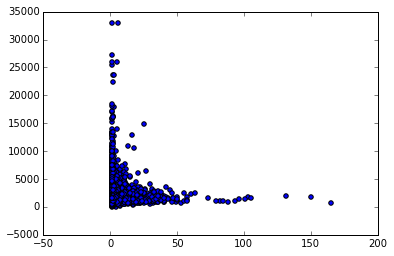

('Talk_Count', 'Unnamed: 0')


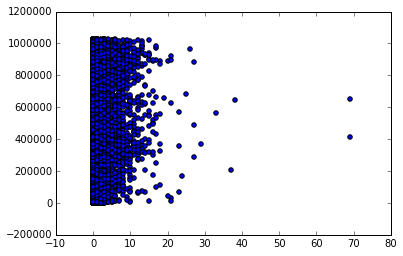

('Talk_Count', 'user_id')


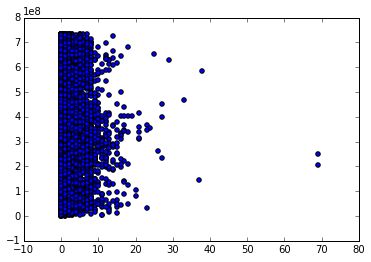

('Talk_Count', 'First_Lead_Price')


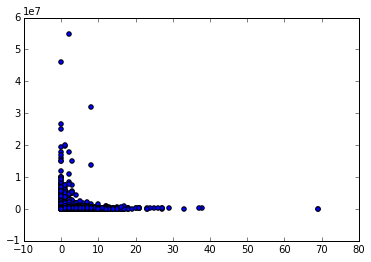

('Talk_Count', 'Avg_Lead_Price')


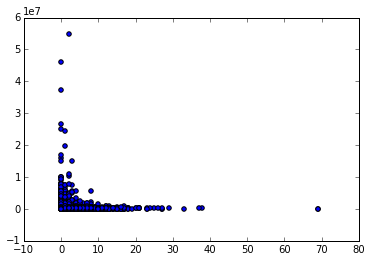

('Talk_Count', 'Max_Lead_Price')


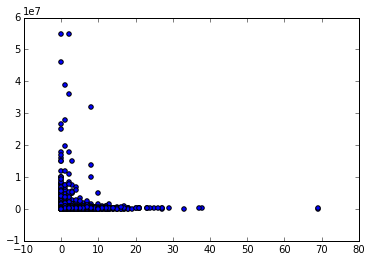

('Talk_Count', 'Min_Lead_Price')


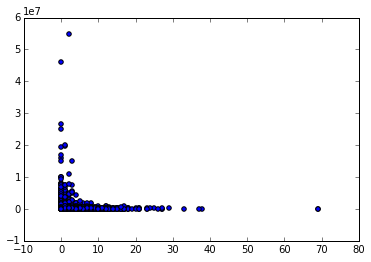

('Talk_Count', 'Leads_Submitted')


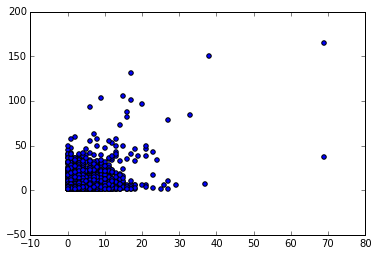

('Talk_Count', 'Talk_Count')


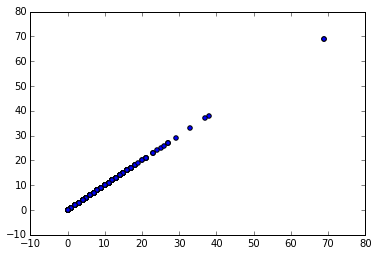

('Talk_Count', 'Met')


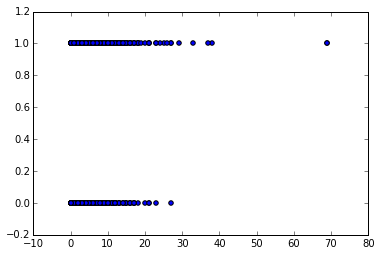

('Talk_Count', 'Saved_Searches')


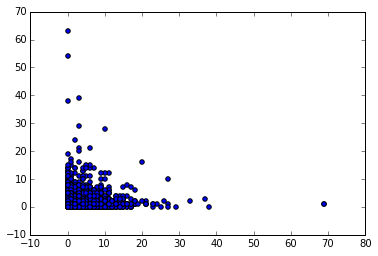

('Talk_Count', 'Activated')


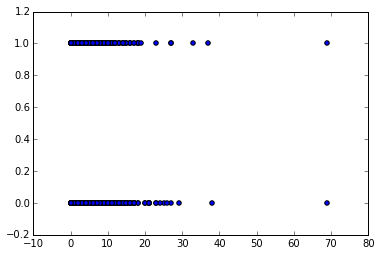

('Talk_Count', 'Registered')


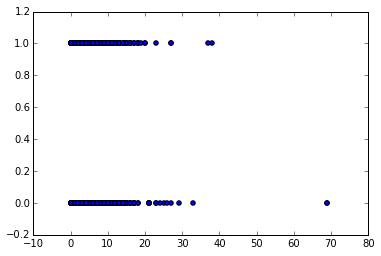

('Talk_Count', 'Spanish')


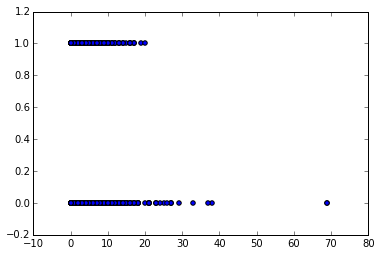

('Talk_Count', 'bedrooms')


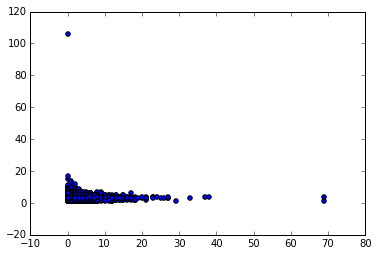

('Talk_Count', 'bathrooms')


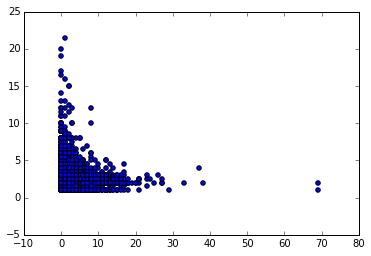

('Talk_Count', 'square_feet')


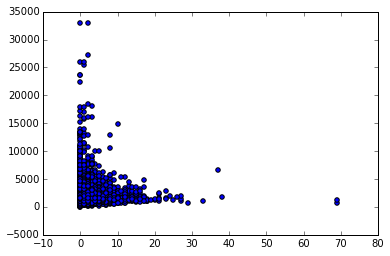

('Met', 'Unnamed: 0')


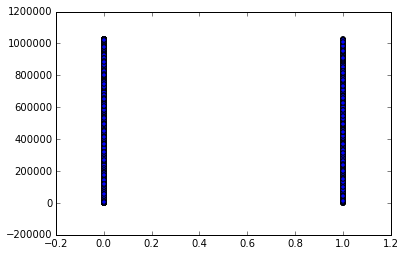

('Met', 'user_id')


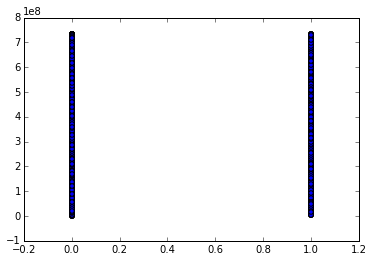

('Met', 'First_Lead_Price')


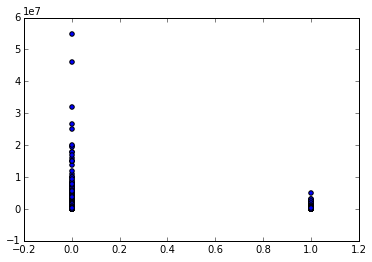

('Met', 'Avg_Lead_Price')


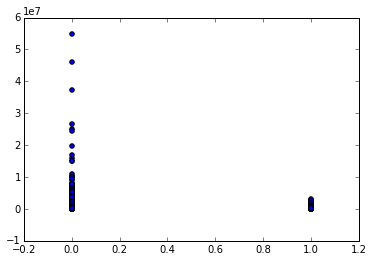

('Met', 'Max_Lead_Price')


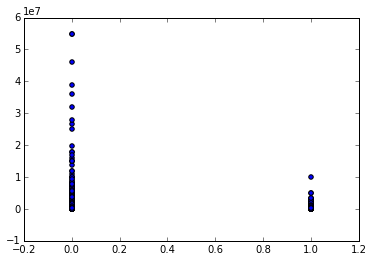

('Met', 'Min_Lead_Price')


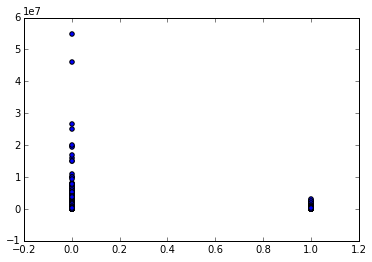

('Met', 'Leads_Submitted')


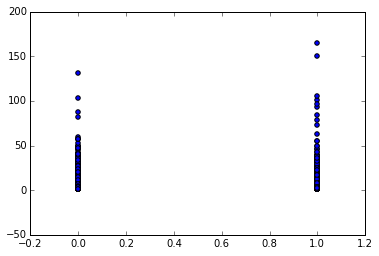

('Met', 'Talk_Count')


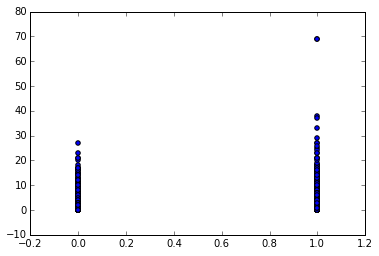

('Met', 'Met')


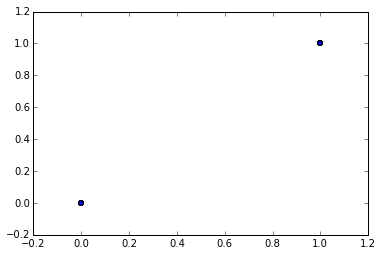

('Met', 'Saved_Searches')


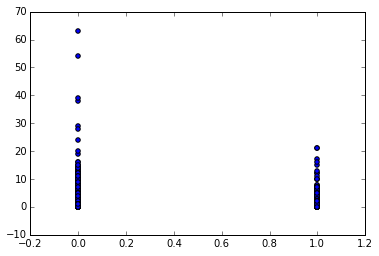

('Met', 'Activated')


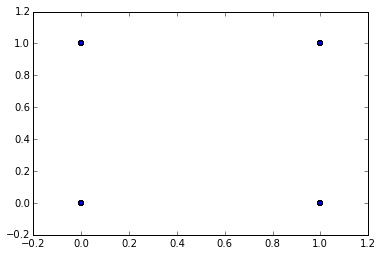

('Met', 'Registered')


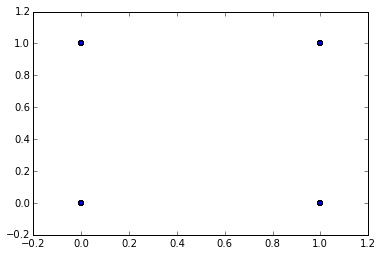

('Met', 'Spanish')


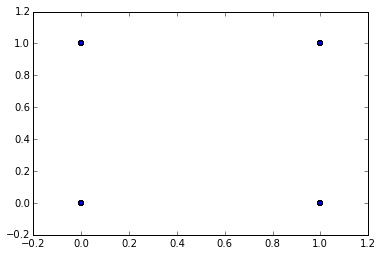

('Met', 'bedrooms')


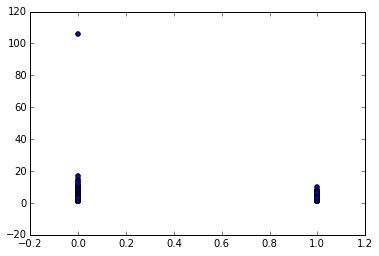

('Met', 'bathrooms')


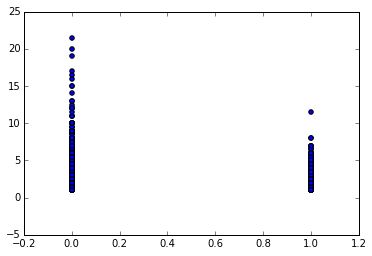

('Met', 'square_feet')


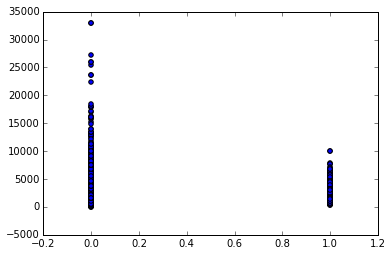

('Saved_Searches', 'Unnamed: 0')


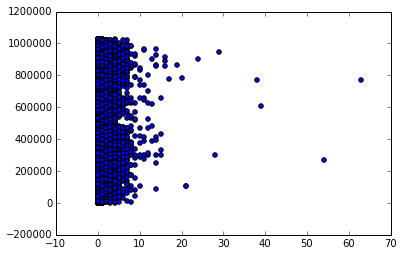

('Saved_Searches', 'user_id')


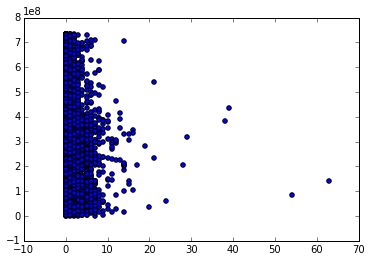

('Saved_Searches', 'First_Lead_Price')


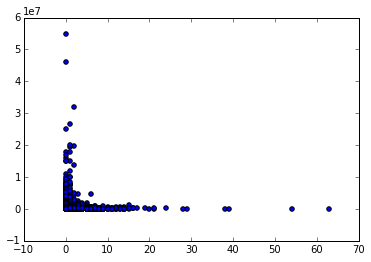

('Saved_Searches', 'Avg_Lead_Price')


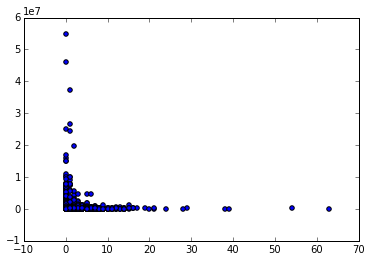

('Saved_Searches', 'Max_Lead_Price')


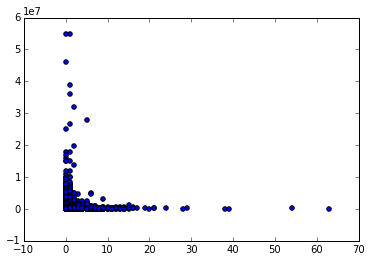

('Saved_Searches', 'Min_Lead_Price')


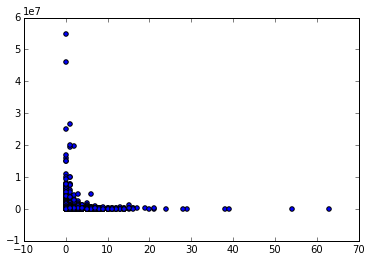

('Saved_Searches', 'Leads_Submitted')


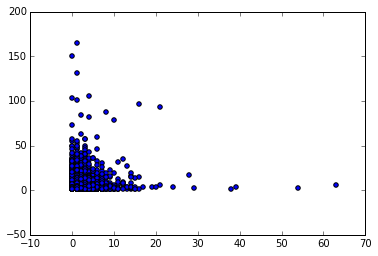

('Saved_Searches', 'Talk_Count')


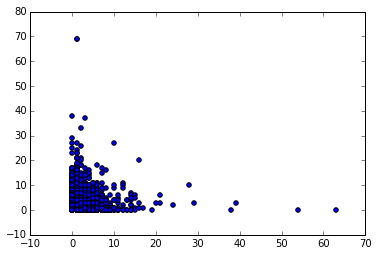

('Saved_Searches', 'Met')


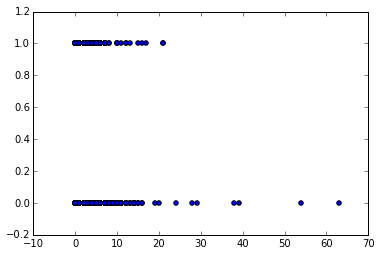

('Saved_Searches', 'Saved_Searches')


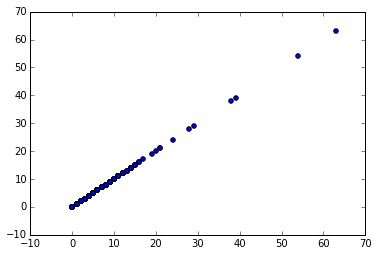

('Saved_Searches', 'Activated')


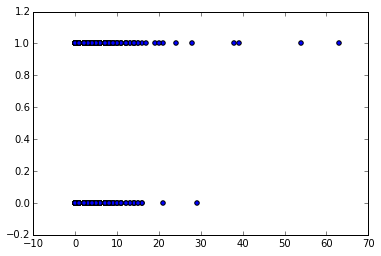

('Saved_Searches', 'Registered')


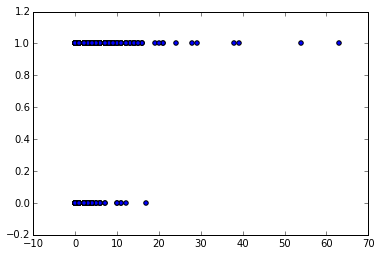

('Saved_Searches', 'Spanish')


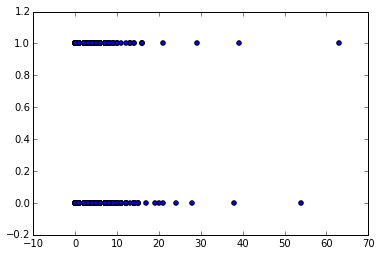

('Saved_Searches', 'bedrooms')


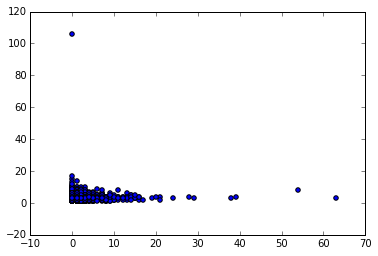

('Saved_Searches', 'bathrooms')


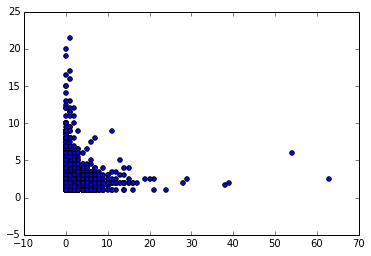

('Saved_Searches', 'square_feet')


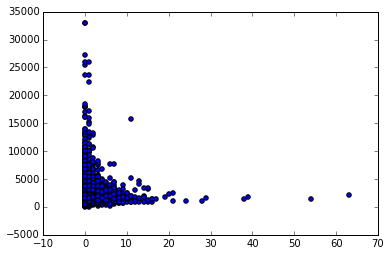

('Activated', 'Unnamed: 0')


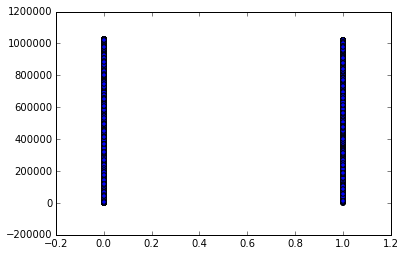

('Activated', 'user_id')


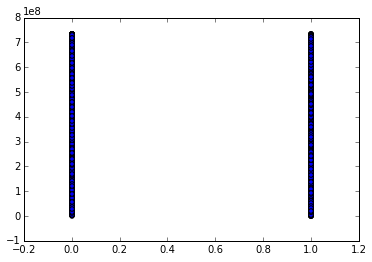

('Activated', 'First_Lead_Price')


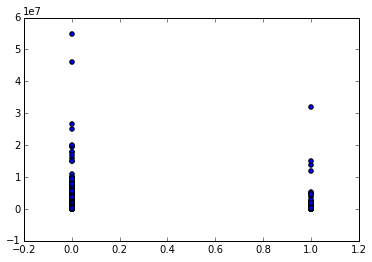

('Activated', 'Avg_Lead_Price')


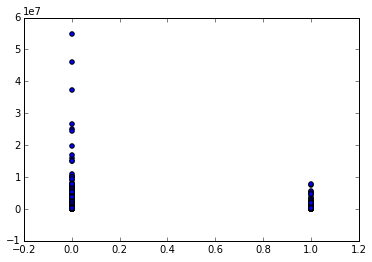

('Activated', 'Max_Lead_Price')


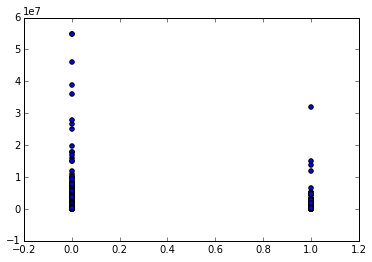

('Activated', 'Min_Lead_Price')


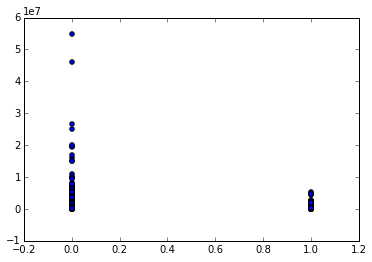

('Activated', 'Leads_Submitted')


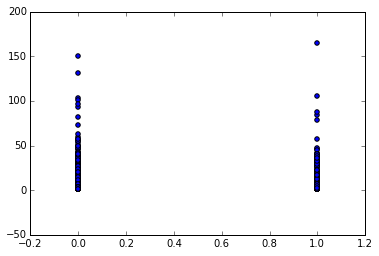

('Activated', 'Talk_Count')


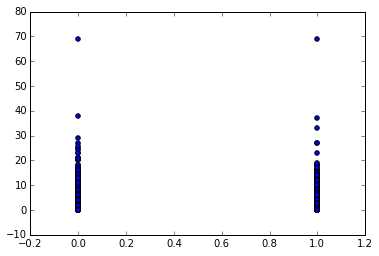

('Activated', 'Met')


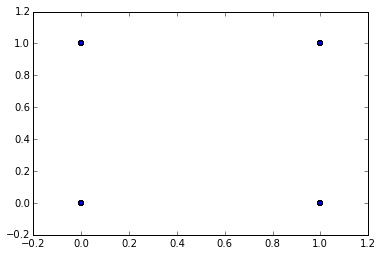

('Activated', 'Saved_Searches')


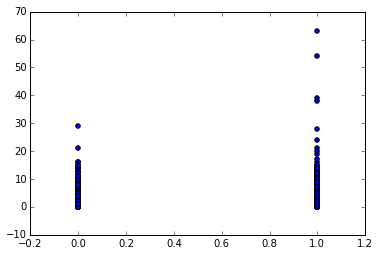

('Activated', 'Activated')


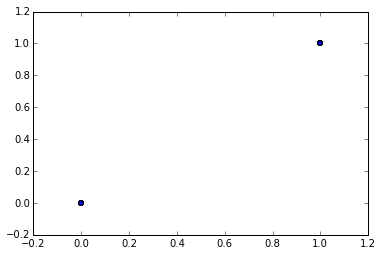

('Activated', 'Registered')


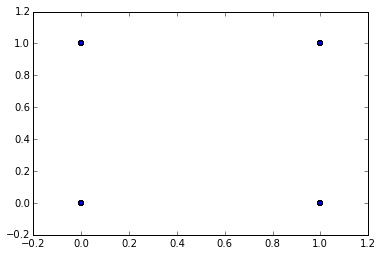

('Activated', 'Spanish')


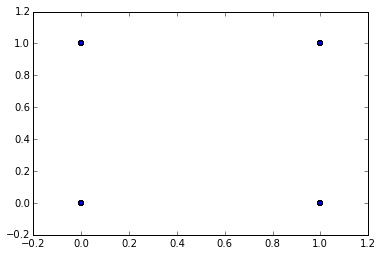

('Activated', 'bedrooms')


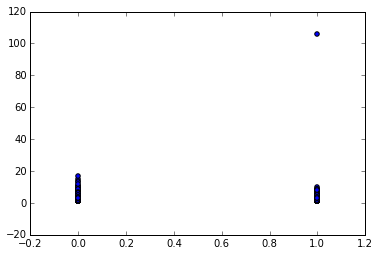

('Activated', 'bathrooms')


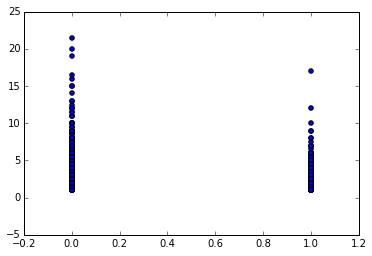

('Activated', 'square_feet')


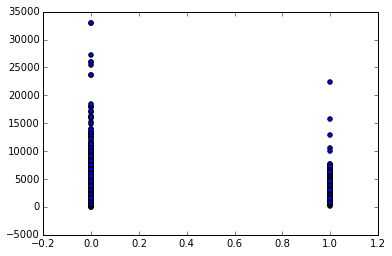

('Registered', 'Unnamed: 0')


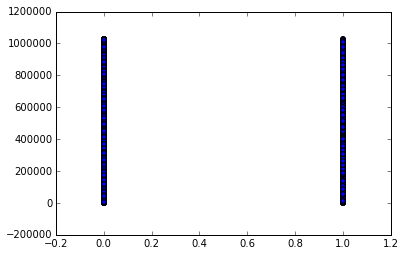

('Registered', 'user_id')


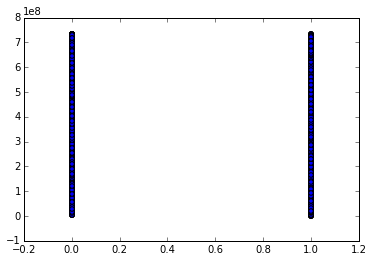

('Registered', 'First_Lead_Price')


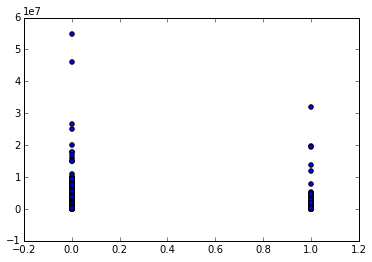

('Registered', 'Avg_Lead_Price')


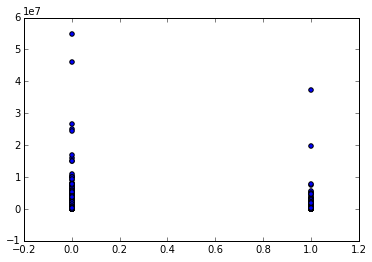

('Registered', 'Max_Lead_Price')


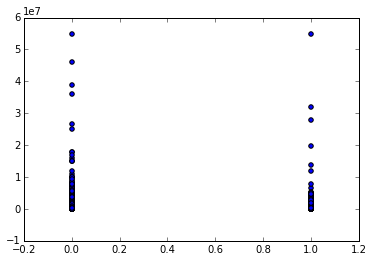

('Registered', 'Min_Lead_Price')


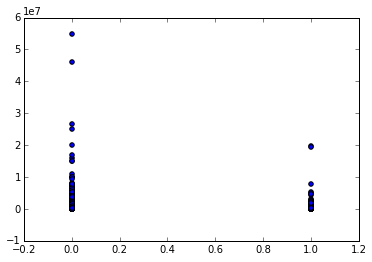

('Registered', 'Leads_Submitted')


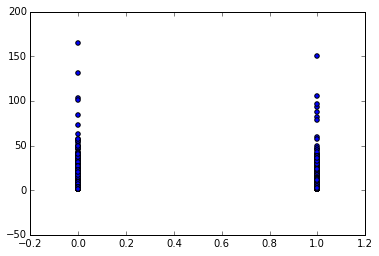

('Registered', 'Talk_Count')


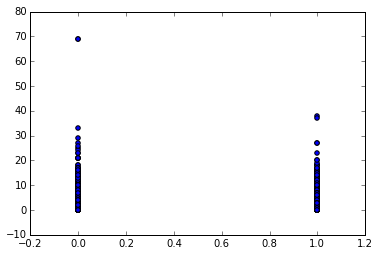

('Registered', 'Met')


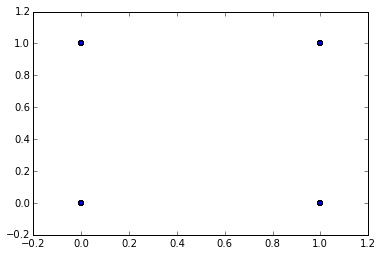

('Registered', 'Saved_Searches')


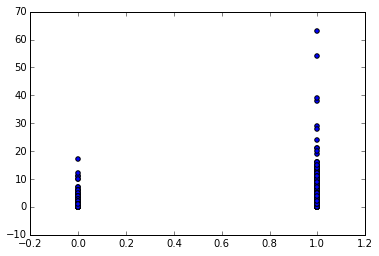

('Registered', 'Activated')


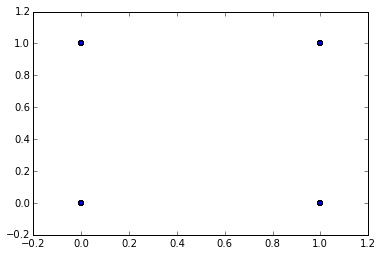

('Registered', 'Registered')


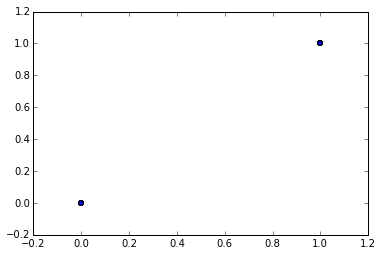

('Registered', 'Spanish')


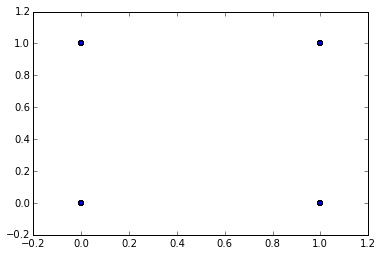

('Registered', 'bedrooms')


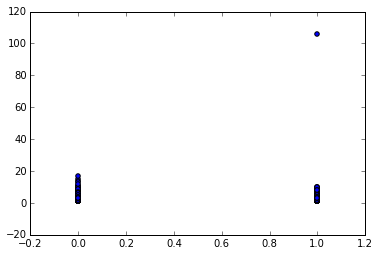

('Registered', 'bathrooms')


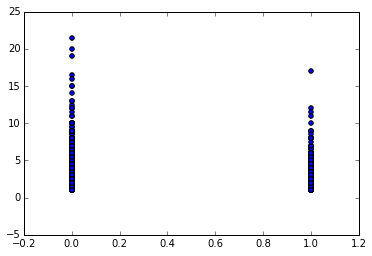

('Registered', 'square_feet')


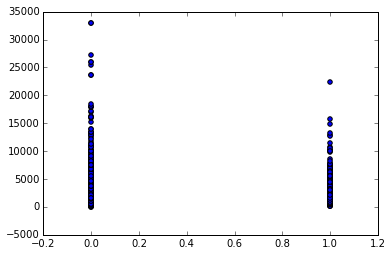

('Spanish', 'Unnamed: 0')


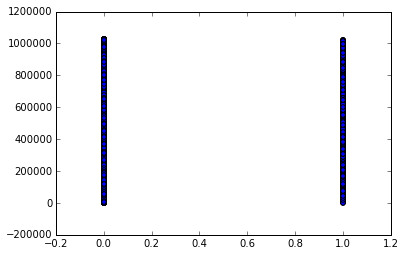

('Spanish', 'user_id')


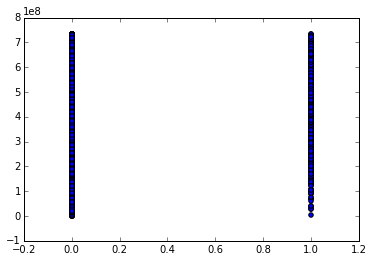

('Spanish', 'First_Lead_Price')


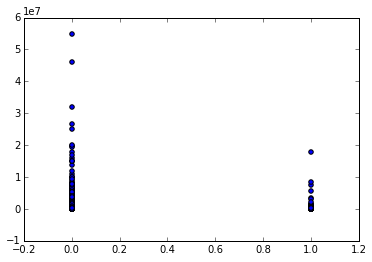

('Spanish', 'Avg_Lead_Price')


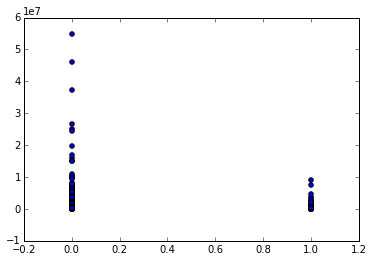

('Spanish', 'Max_Lead_Price')


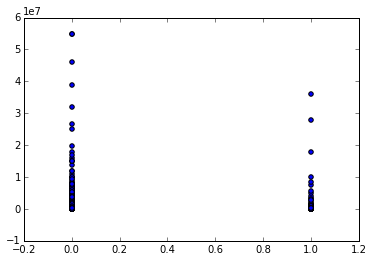

('Spanish', 'Min_Lead_Price')


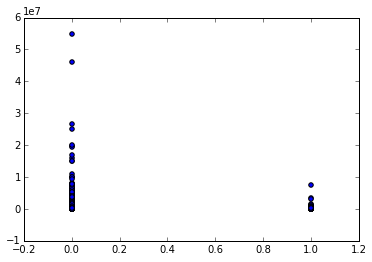

('Spanish', 'Leads_Submitted')


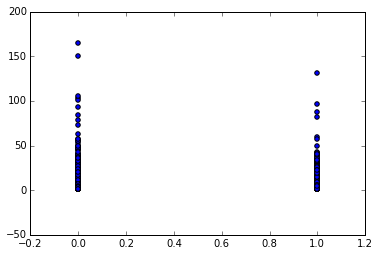

('Spanish', 'Talk_Count')


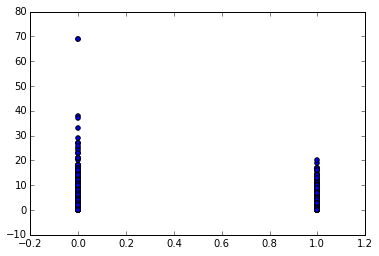

('Spanish', 'Met')


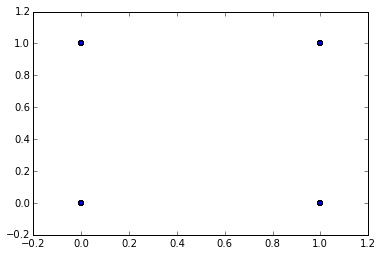

('Spanish', 'Saved_Searches')


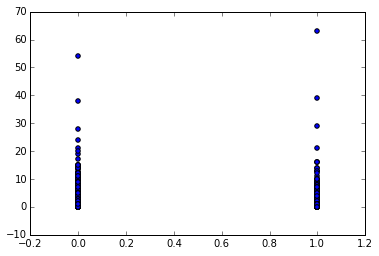

('Spanish', 'Activated')


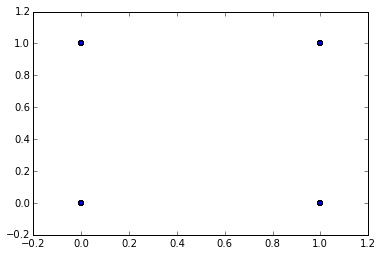

('Spanish', 'Registered')


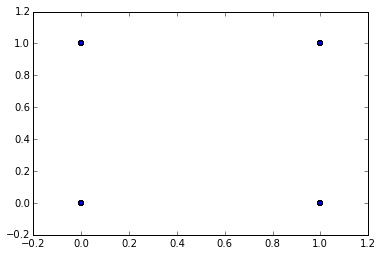

('Spanish', 'Spanish')


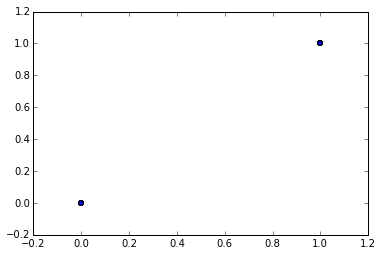

('Spanish', 'bedrooms')


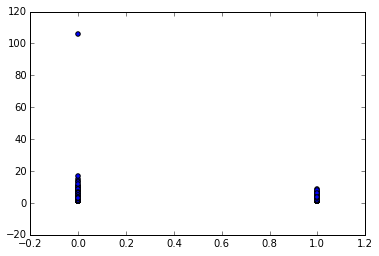

('Spanish', 'bathrooms')


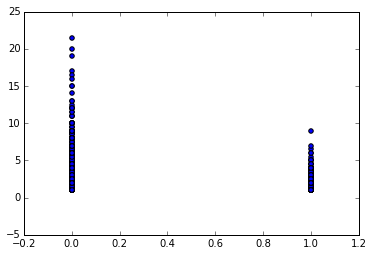

('Spanish', 'square_feet')


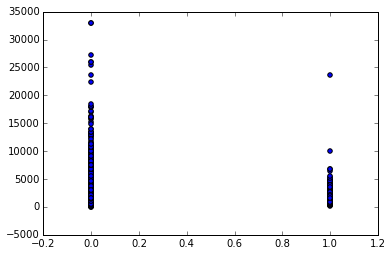

('bedrooms', 'Unnamed: 0')


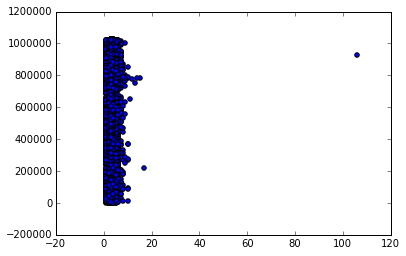

('bedrooms', 'user_id')


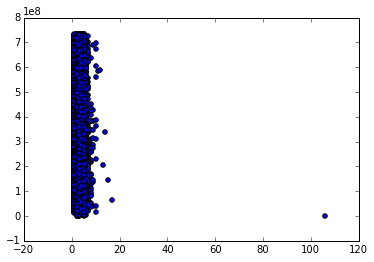

('bedrooms', 'First_Lead_Price')


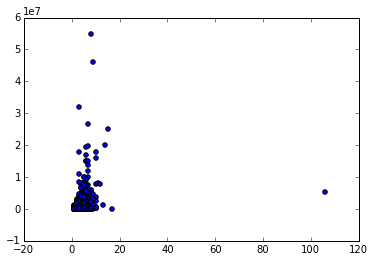

('bedrooms', 'Avg_Lead_Price')


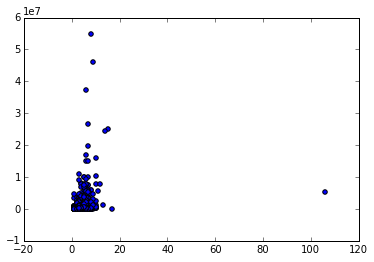

('bedrooms', 'Max_Lead_Price')


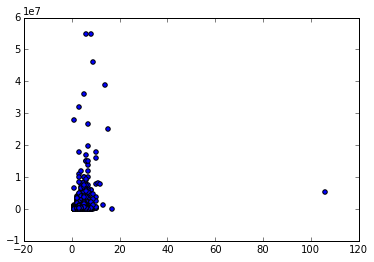

('bedrooms', 'Min_Lead_Price')


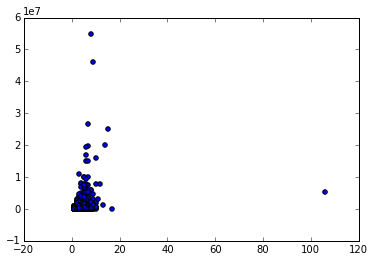

('bedrooms', 'Leads_Submitted')


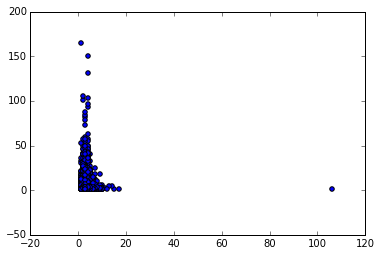

('bedrooms', 'Talk_Count')


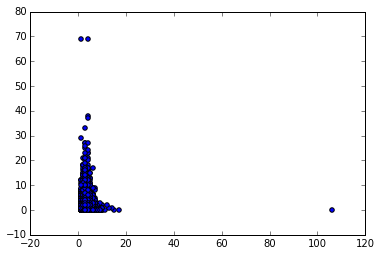

('bedrooms', 'Met')


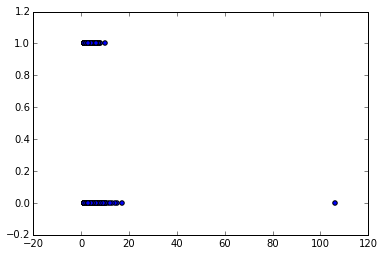

('bedrooms', 'Saved_Searches')


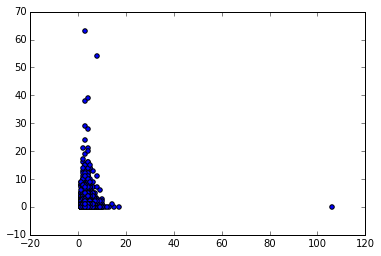

('bedrooms', 'Activated')


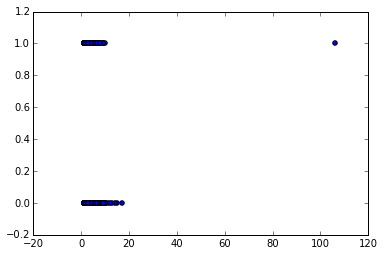

('bedrooms', 'Registered')


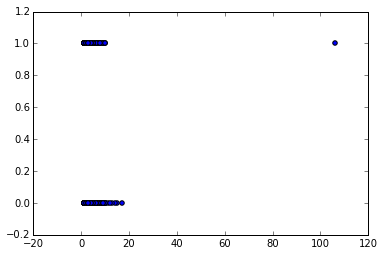

('bedrooms', 'Spanish')


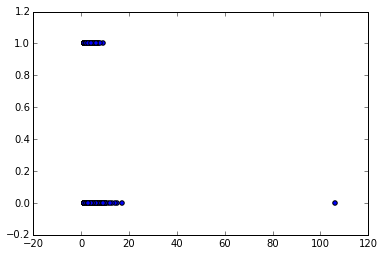

('bedrooms', 'bedrooms')


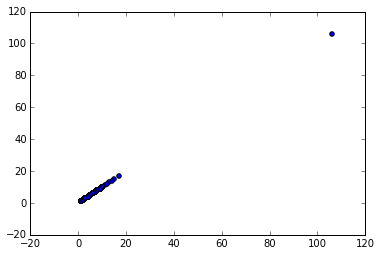

('bedrooms', 'bathrooms')


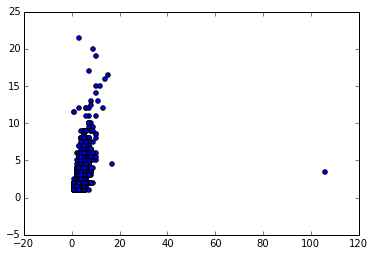

('bedrooms', 'square_feet')


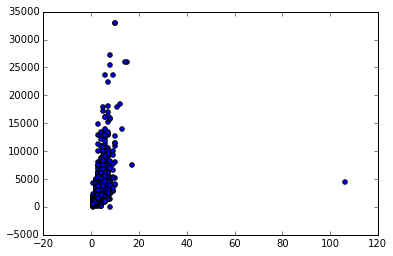

('bathrooms', 'Unnamed: 0')


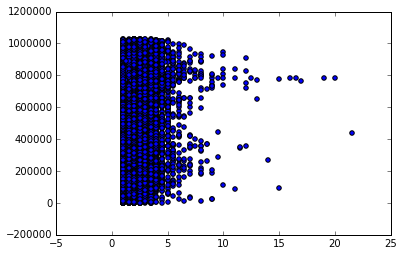

('bathrooms', 'user_id')


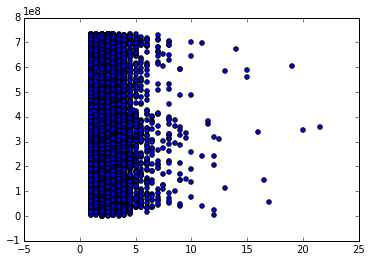

('bathrooms', 'First_Lead_Price')


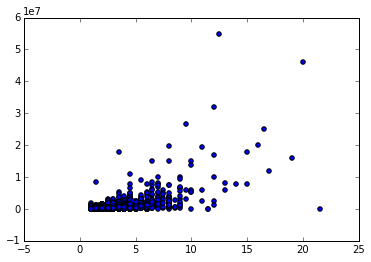

('bathrooms', 'Avg_Lead_Price')


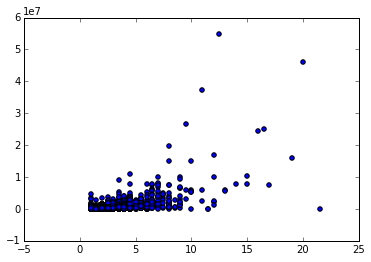

('bathrooms', 'Max_Lead_Price')


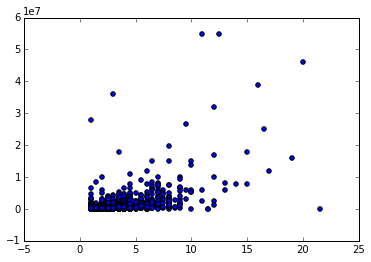

('bathrooms', 'Min_Lead_Price')


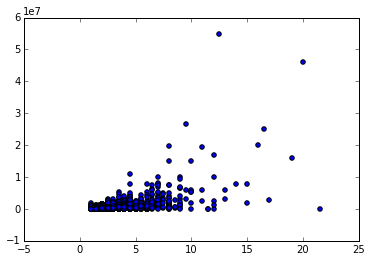

('bathrooms', 'Leads_Submitted')


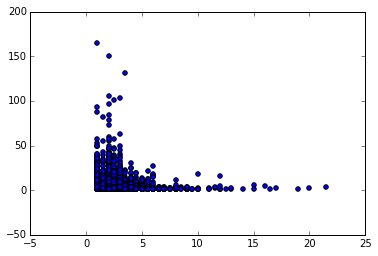

('bathrooms', 'Talk_Count')


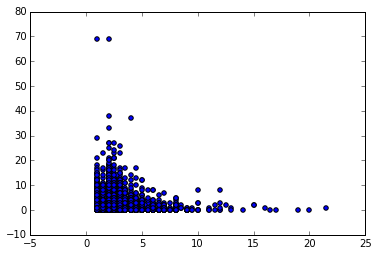

('bathrooms', 'Met')


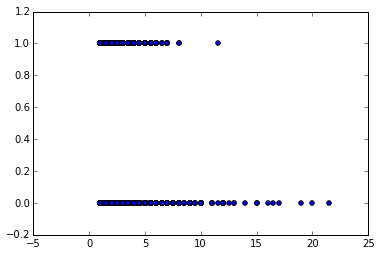

('bathrooms', 'Saved_Searches')


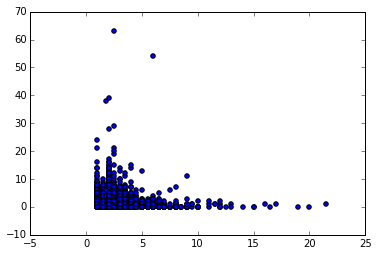

('bathrooms', 'Activated')


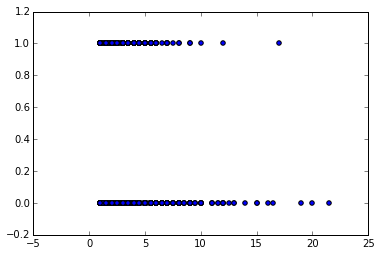

('bathrooms', 'Registered')


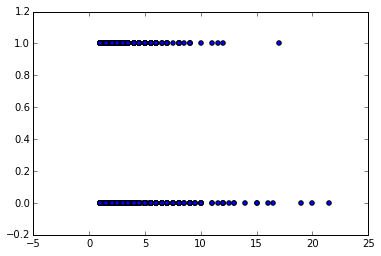

('bathrooms', 'Spanish')


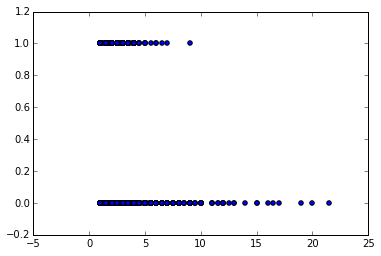

('bathrooms', 'bedrooms')


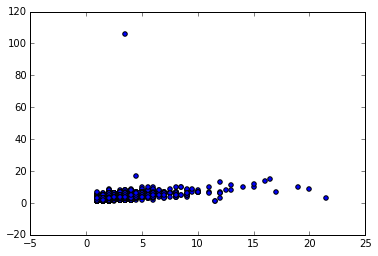

('bathrooms', 'bathrooms')


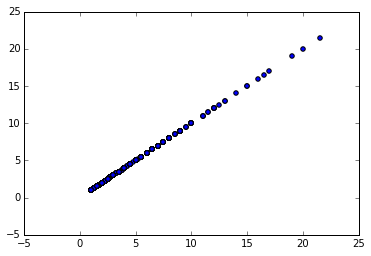

('bathrooms', 'square_feet')


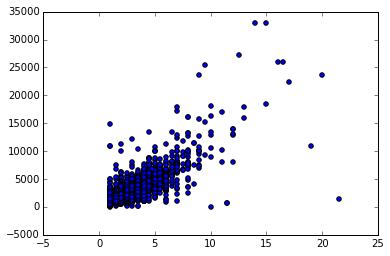

('square_feet', 'Unnamed: 0')


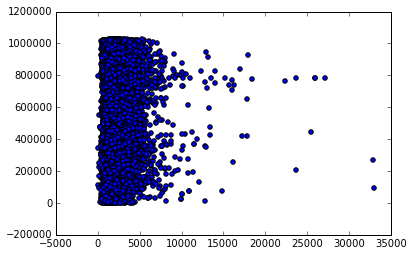

('square_feet', 'user_id')


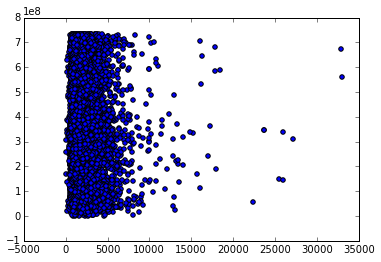

('square_feet', 'First_Lead_Price')


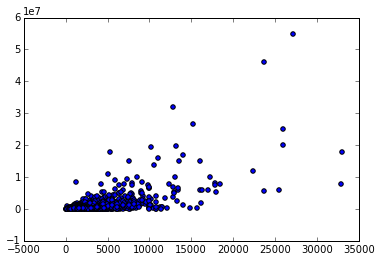

('square_feet', 'Avg_Lead_Price')


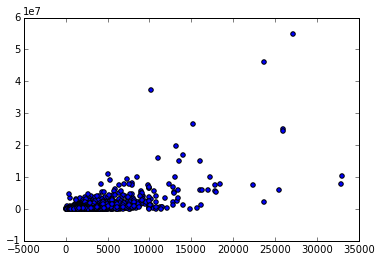

('square_feet', 'Max_Lead_Price')


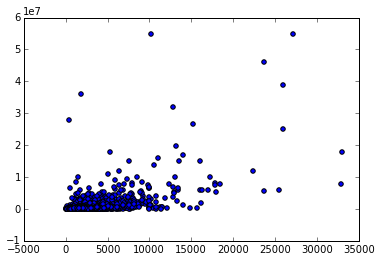

('square_feet', 'Min_Lead_Price')


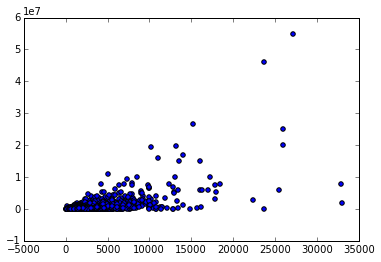

('square_feet', 'Leads_Submitted')


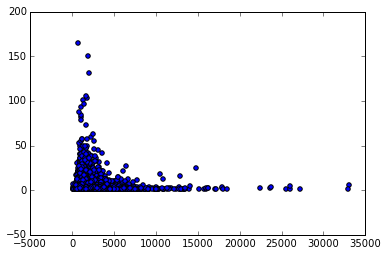

('square_feet', 'Talk_Count')


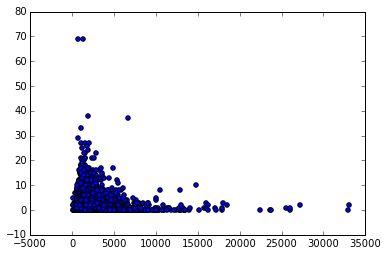

('square_feet', 'Met')


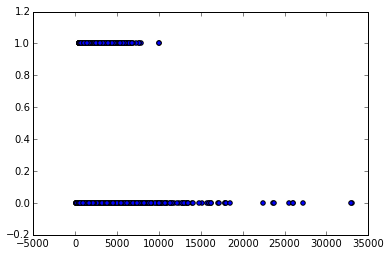

('square_feet', 'Saved_Searches')


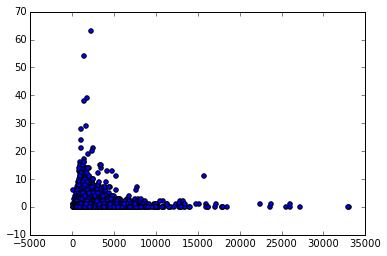

('square_feet', 'Activated')


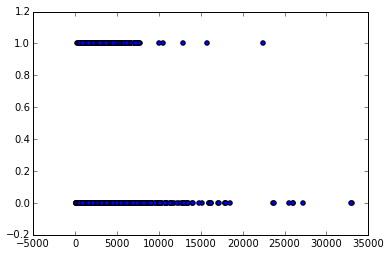

('square_feet', 'Registered')


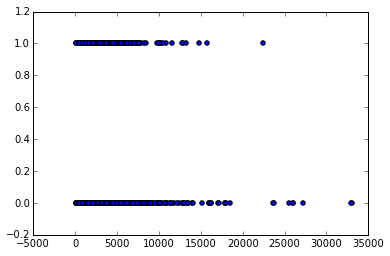

('square_feet', 'Spanish')


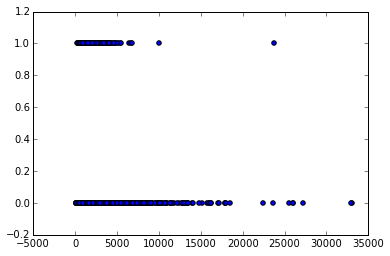

('square_feet', 'bedrooms')


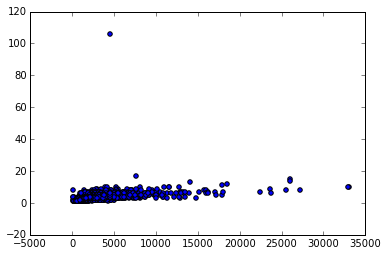

('square_feet', 'bathrooms')


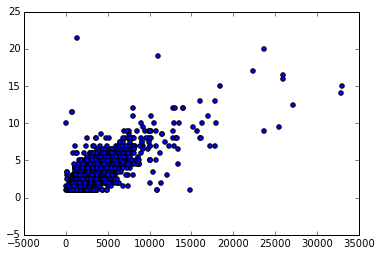

('square_feet', 'square_feet')


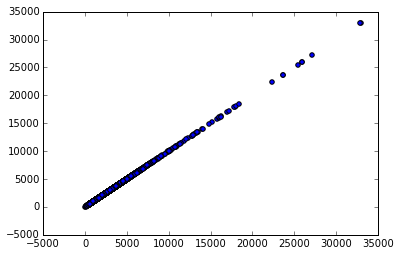

In [5]:
out = ['First_Lead_Platform', 'State']
for i in leads:
    if i not in out:
        for j in leads:
            if j not in out:
                print(i,j)
                plt.scatter(leads[i], leads[j])
                plt.show()